### Импорт

In [1]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 5.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
import gensim
from torchmetrics.functional import f1, recall, accuracy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Данные

In [5]:
!unzip '/content/drive/MyDrive/HW_3/Fake.csv.zip'

Archive:  /content/drive/MyDrive/HW_3/Fake.csv.zip
  inflating: Fake.csv                


In [6]:
def preprocessing(text):
    text = word_tokenize(text.lower())
    return text


#  препроцессинг
data = pd.read_csv('Fake.csv')
texts = (data['title'] + ' ' + data['text']).tolist()
X = [preprocessing(text) for text in texts]
X_lengths = [len(text) for text in X]

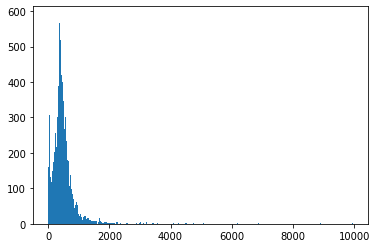

In [7]:
data['length'] = X_lengths
plt.hist(X_lengths, bins=1000)
plt.show()

In [8]:
max(X_lengths)

9950

In [9]:
sum(X_lengths) / len(X_lengths)

487.5177803330352

In [10]:
data.shape

(23481, 5)

In [11]:
data[data['length'] > 1000].shape

(1319, 5)

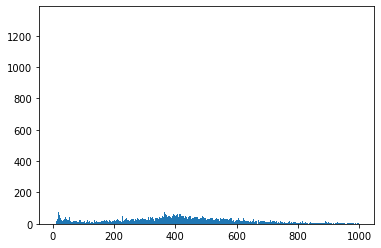

In [12]:
#  режу до тысячи
for num, text in enumerate(X):
    if len(text) > 1000:
        text = text[:1000]
        X[num] = text

X_lengths = [len(text) for text in X]
plt.hist(X_lengths, bins=1000)
plt.show()

In [13]:
# составляем вокабуляр
vocab = []
[vocab.extend(text) for text in X]
vocab = Counter(vocab)
filtered_vocab = set()
for word, count in vocab.items():
    if count > 10:
        filtered_vocab.add(word)
vocab = filtered_vocab

#  создание словарей для кодирования и декодирования
word2id = {'PAD':0,}
for word in vocab:
    word2id[word] = len(word2id)
#  добавим токен, чтобы ловить отфильтрованные/отсутствующие в предобученных векторах слова
word2id['UNK'] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

#  работа с ответами
y = data['subject'].tolist()
subject2id = {c:i for i, c in enumerate(set(y))}
id2subject = {i:c for i, c in enumerate(set(y))}

In [14]:
class NewsDataset(Dataset):
    def __init__(self, word2id, subject2id, data, seq_len, DEVICE):
        super().__init__()
        self.device = DEVICE
        self.X = (data['title'] + ' ' + data['text']).tolist()
        self.y = data['subject'].tolist()
        self.word2id = word2id
        self.vocab_size = len(word2id) 
        self.subject2id = subject2id 
        self.seq_len = seq_len  

    
    def __getitem__(self, index):
        x = self.X[index]
        x = preprocessing(x)
        for num, word in enumerate(x):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x[num] = word
        x = torch.LongTensor(x)
        if len(x) > self.seq_len:
            x = x[:self.seq_len]
        y = self.y[index]
        y = self.subject2id[y]
        return x, y
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

    def preprocessing(text):
        text = word_tokenize(text.lower())
        return text

In [15]:
data = shuffle(data[['title', 'text', 'subject']])
train_texts, val_texts = train_test_split(data, test_size=0.1)

train_dataset = NewsDataset(word2id, subject2id, train_texts, 1000, DEVICE)
train_sampler = SequentialSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=512)

val_dataset = NewsDataset(word2id, subject2id, val_texts, 1000, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=512)

### Эмбеддинги
https://code.google.com/archive/p/word2vec/

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/HW_3/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [17]:
len(word2id)

24313

In [18]:
weight_matrix = []

for word in word2id.keys():
    if word == 'PAD':
        vec = torch.zeros(1, 300)
    elif (word == 'UNK')or(word not in model.vocab):
        vec = (0.25 + 0.25)*torch.rand((1, 300)) - 0.25
    elif word in model.vocab:
        vec = torch.as_tensor(model[word]).unsqueeze(dim=0)
    
    weight_matrix.append(vec)


weight_matrix = torch.cat(weight_matrix, dim=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  if __name__ == '__main__':


In [19]:
weight_matrix.shape

torch.Size([24313, 300])

In [20]:
del model

### Архитектура

In [22]:
class C_LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, weight_matrix, number_of_CNN_layers, filter_count, kernel_sizes, seq_len, lstm_size, subject_num, dropout_place, dropout_rate, device=DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.weight_matrix = weight_matrix.to(device)
        self.number_of_CNN_layers = number_of_CNN_layers
        self.filter_count= filter_count
        self.kernel_sizes = kernel_sizes
        self.seq_len = seq_len
        self.post_CNN_seq_len = self.seq_len - max(self.kernel_sizes) + 1
        self.lstm_size = lstm_size
        self.subject_num = subject_num
        self.dropout_place = dropout_place
        self.dropout_rate = dropout_rate

        self.embedding = torch.nn.Embedding.from_pretrained(torch.cuda.FloatTensor(self.weight_matrix), freeze=False)

        self.dropout = nn.Dropout(self.dropout_rate)

        self.CNNs = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, 
                                              out_channels=self.filter_count, 
                                              kernel_size=kernel_size, 
                                              padding='same') for kernel_size in self.kernel_sizes])
        
        self.lstm = nn.LSTM(input_size=self.post_CNN_seq_len,
                            hidden_size=self.lstm_size,
                            num_layers=1,
                            batch_first=True)
        self.linear = nn.Linear(self.lstm_size, self.subject_num)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, text):
        #  batch_size x seq_len
        embedded = self.embedding(text)
        #  batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(2, 1)
        #  batch_size x embedding_dim x seq_len 
        if self.dropout_place == 'before CNN':
            embedded = self.dropout(embedded)
        feature_maps = [CNN(embedded) for CNN in self.CNNs]
        #  every feature map: batch_size x filter_count x post_CNN_seq_len, where post_CNN_seq_len depends on the implemented kernel_size
        feature_maps = [map[:, :, :self.post_CNN_seq_len] for map in feature_maps]
        #  every feature_map: batch_size x filter_count x self.post_CNN_seq_len, where self.post_CNN_seq_len belongs to the biggest kernel_size
        feature_map = torch.cat(feature_maps, dim=1)
        #  batch_size x (filter_count * len(feature_maps)) x self.post_CNN_seq_len
        output, (h_state, c_state) = self.lstm(feature_map)
        if self.dropout_place == 'before Softmax':
            h_state = self.dropout(h_state)
        #  batch_size x 1 x lstm_size
        h_state = h_state.squeeze(dim=0)
        #  batch_size x lstm_size
        logits = self.linear(h_state)
        #  batch_size x subject_num
        logits = self.softmax(logits)
        #  batch_size x subject_num

        return logits

### Функции обучения и валидации

In [23]:
def train(model, iterator, optimizer, criterion, device=DEVICE):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in tqdm(enumerate(iterator)): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys.long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i + 1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    epoch_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys.long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds, ys.long())
            epoch_metric += batch_metric
            epoch_accuracy += accuracy(preds.argmax(dim=1), ys.long())

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i + 1)}, Val f1: {epoch_metric/(i + 1)}, Val accuracy: {epoch_accuracy/(i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### Эксперименты: нет дропаута, kernel_size = 2

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[2], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:18,  2.25s/it]

Train loss: 1.7237198948860168


16it [00:36,  2.33s/it]

Train loss: 1.6761875078082085


24it [00:55,  2.32s/it]

Train loss: 1.6446385979652405


32it [01:13,  2.27s/it]

Train loss: 1.624592661857605


40it [01:33,  2.37s/it]

Train loss: 1.6077714055776595


42it [01:36,  2.29s/it]



Evaluating on train...


8it [00:14,  1.81s/it]

Val loss: 1.523879423737526, Val f1: 0.52197265625, Val accuracy: 0.52197265625


16it [00:29,  1.88s/it]

Val loss: 1.5224788039922714, Val f1: 0.5240478515625, Val accuracy: 0.5240478515625


24it [00:44,  1.85s/it]

Val loss: 1.5199848810831706, Val f1: 0.526611328125, Val accuracy: 0.526611328125


32it [00:59,  1.83s/it]

Val loss: 1.5210144817829132, Val f1: 0.52490234375, Val accuracy: 0.52490234375


40it [01:14,  1.86s/it]

Val loss: 1.5217869877815247, Val f1: 0.523974597454071, Val accuracy: 0.523974597454071


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5242877006530762, Val f1: 0.52734375, Val accuracy: 0.52734375


2it [00:03,  1.86s/it]

Val loss: 1.5040462017059326, Val f1: 0.548828125, Val accuracy: 0.548828125


3it [00:05,  1.84s/it]

Val loss: 1.5232477188110352, Val f1: 0.52734375, Val accuracy: 0.52734375


4it [00:07,  1.86s/it]

Val loss: 1.5202251374721527, Val f1: 0.52685546875, Val accuracy: 0.52685546875


5it [00:08,  1.71s/it]


Val loss: 1.5233073949813842, Val f1: 0.5238099694252014, Val accuracy: 0.5238099694252014

starting Epoch 1
Training...


8it [00:18,  2.23s/it]

Train loss: 1.5330529808998108


16it [00:36,  2.32s/it]

Train loss: 1.5324956178665161


24it [00:55,  2.30s/it]

Train loss: 1.5308752357959747


32it [01:13,  2.25s/it]

Train loss: 1.5288358181715012


40it [01:31,  2.30s/it]

Train loss: 1.5306946605443954


42it [01:36,  2.30s/it]



Evaluating on train...


8it [00:19,  2.64s/it]

Val loss: 1.5410558730363846, Val f1: 0.498046875, Val accuracy: 0.498046875


16it [00:45,  2.99s/it]

Val loss: 1.5453097373247147, Val f1: 0.49462890625, Val accuracy: 0.49462890625


24it [01:05,  2.36s/it]

Val loss: 1.545943523446719, Val f1: 0.4933268427848816, Val accuracy: 0.4933268427848816


32it [01:24,  2.08s/it]

Val loss: 1.5439879931509495, Val f1: 0.49591064453125, Val accuracy: 0.49591064453125


40it [01:39,  1.88s/it]

Val loss: 1.543830531835556, Val f1: 0.497314453125, Val accuracy: 0.497314453125


42it [01:41,  2.42s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.557237148284912, Val f1: 0.470703125, Val accuracy: 0.470703125


2it [00:03,  1.90s/it]

Val loss: 1.5332444310188293, Val f1: 0.498046875, Val accuracy: 0.498046875


3it [00:05,  1.86s/it]

Val loss: 1.5458353360493977, Val f1: 0.4889323115348816, Val accuracy: 0.4889323115348816


4it [00:07,  1.87s/it]

Val loss: 1.54184952378273, Val f1: 0.494140625, Val accuracy: 0.494140625


5it [00:08,  1.72s/it]


Val loss: 1.5438453912734986, Val f1: 0.49298691749572754, Val accuracy: 0.49298691749572754

starting Epoch 2
Training...


8it [00:18,  2.24s/it]

Train loss: 1.5281320065259933


16it [00:37,  2.39s/it]

Train loss: 1.533933825790882


24it [00:56,  2.28s/it]

Train loss: 1.5283469905455906


32it [01:14,  2.29s/it]

Train loss: 1.5297715552151203


40it [01:45,  4.00s/it]

Train loss: 1.5294241726398468


42it [01:50,  2.63s/it]



Evaluating on train...


8it [00:22,  2.91s/it]

Val loss: 1.5872766226530075, Val f1: 0.45263671875, Val accuracy: 0.45263671875


16it [00:47,  3.04s/it]

Val loss: 1.5910934507846832, Val f1: 0.4478759765625, Val accuracy: 0.4478759765625


24it [01:12,  2.59s/it]

Val loss: 1.589506243666013, Val f1: 0.4491373896598816, Val accuracy: 0.4491373896598816


32it [01:28,  1.93s/it]

Val loss: 1.589800301939249, Val f1: 0.449462890625, Val accuracy: 0.449462890625


40it [01:50,  2.89s/it]

Val loss: 1.589944702386856, Val f1: 0.44941407442092896, Val accuracy: 0.44941407442092896


42it [01:54,  2.73s/it]



Evaluating on test...


1it [00:04,  4.12s/it]

Val loss: 1.6076616048812866, Val f1: 0.421875, Val accuracy: 0.421875


2it [00:07,  3.92s/it]

Val loss: 1.5806350708007812, Val f1: 0.455078125, Val accuracy: 0.455078125


3it [00:11,  3.97s/it]

Val loss: 1.5935256878534954, Val f1: 0.4440104365348816, Val accuracy: 0.4440104365348816


4it [00:14,  3.43s/it]

Val loss: 1.5932226479053497, Val f1: 0.4453125, Val accuracy: 0.4453125


5it [00:15,  3.13s/it]


Val loss: 1.5946540117263794, Val f1: 0.44462209939956665, Val accuracy: 0.44462209939956665

starting Epoch 3
Training...


8it [00:18,  2.24s/it]

Train loss: 1.5445700287818909


16it [00:36,  2.29s/it]

Train loss: 1.5325931757688522


24it [00:55,  2.30s/it]

Train loss: 1.5260773499806721


32it [01:13,  2.27s/it]

Train loss: 1.5280261486768723


40it [01:32,  2.33s/it]

Train loss: 1.5273358255624772


42it [01:35,  2.28s/it]



Evaluating on train...


8it [00:15,  1.84s/it]

Val loss: 1.5725976675748825, Val f1: 0.462890625, Val accuracy: 0.462890625


16it [00:30,  1.91s/it]

Val loss: 1.5765202045440674, Val f1: 0.4610595703125, Val accuracy: 0.4610595703125


24it [00:46,  2.02s/it]

Val loss: 1.5769309550523758, Val f1: 0.46044921875, Val accuracy: 0.46044921875


32it [01:01,  1.86s/it]

Val loss: 1.575337015092373, Val f1: 0.4625244140625, Val accuracy: 0.4625244140625


40it [01:16,  1.86s/it]

Val loss: 1.5745362490415573, Val f1: 0.4634765684604645, Val accuracy: 0.4634765684604645


42it [01:19,  1.88s/it]



Evaluating on test...


1it [00:01,  1.85s/it]

Val loss: 1.5843415260314941, Val f1: 0.45703125, Val accuracy: 0.45703125


2it [00:03,  1.86s/it]

Val loss: 1.5640767216682434, Val f1: 0.47265625, Val accuracy: 0.47265625


3it [00:05,  1.83s/it]

Val loss: 1.5744318564732869, Val f1: 0.4596354365348816, Val accuracy: 0.4596354365348816


4it [00:07,  1.86s/it]

Val loss: 1.570215106010437, Val f1: 0.46337890625, Val accuracy: 0.46337890625


5it [00:08,  1.70s/it]


Val loss: 1.57233669757843, Val f1: 0.4604041278362274, Val accuracy: 0.4604041278362274

starting Epoch 4
Training...


8it [00:17,  2.21s/it]

Train loss: 1.533100962638855


16it [00:36,  2.30s/it]

Train loss: 1.5269732996821404


24it [00:55,  2.34s/it]

Train loss: 1.523818165063858


32it [01:13,  2.26s/it]

Train loss: 1.5245639979839325


40it [01:32,  2.30s/it]

Train loss: 1.5243278831243514


42it [01:35,  2.27s/it]



Evaluating on train...


8it [00:14,  1.84s/it]

Val loss: 1.5268752425909042, Val f1: 0.513916015625, Val accuracy: 0.513916015625


16it [00:30,  1.90s/it]

Val loss: 1.5287876352667809, Val f1: 0.511962890625, Val accuracy: 0.511962890625


24it [00:45,  1.85s/it]

Val loss: 1.527890349427859, Val f1: 0.5126953125, Val accuracy: 0.5126953125


32it [00:59,  1.83s/it]

Val loss: 1.527296632528305, Val f1: 0.51348876953125, Val accuracy: 0.51348876953125


40it [01:14,  1.87s/it]

Val loss: 1.527935302257538, Val f1: 0.5126953125, Val accuracy: 0.5126953125


42it [01:17,  1.84s/it]



Evaluating on test...


1it [00:01,  1.85s/it]

Val loss: 1.5330815315246582, Val f1: 0.509765625, Val accuracy: 0.509765625


2it [00:03,  1.86s/it]

Val loss: 1.5108928680419922, Val f1: 0.5341796875, Val accuracy: 0.5341796875


3it [00:05,  1.83s/it]

Val loss: 1.5280702114105225, Val f1: 0.5162760615348816, Val accuracy: 0.5162760615348816


4it [00:07,  1.87s/it]

Val loss: 1.5258162319660187, Val f1: 0.51611328125, Val accuracy: 0.51611328125


5it [00:08,  1.71s/it]


Val loss: 1.5286543846130372, Val f1: 0.513222873210907, Val accuracy: 0.513222873210907

starting Epoch 5
Training...


8it [00:18,  2.23s/it]

Train loss: 1.5261329263448715


16it [00:36,  2.30s/it]

Train loss: 1.5229084268212318


24it [00:55,  2.30s/it]

Train loss: 1.5266479154427846


32it [01:13,  2.26s/it]

Train loss: 1.5266183726489544


40it [01:31,  2.32s/it]

Train loss: 1.525684866309166


42it [01:34,  2.26s/it]



Evaluating on train...


8it [00:15,  1.90s/it]

Val loss: 1.5642169713974, Val f1: 0.479736328125, Val accuracy: 0.479736328125


16it [00:30,  1.91s/it]

Val loss: 1.567845992743969, Val f1: 0.4766845703125, Val accuracy: 0.4766845703125


24it [00:45,  1.85s/it]

Val loss: 1.567495788137118, Val f1: 0.4759928584098816, Val accuracy: 0.4759928584098816


32it [01:00,  1.87s/it]

Val loss: 1.566326167434454, Val f1: 0.4781494140625, Val accuracy: 0.4781494140625


40it [01:16,  1.89s/it]

Val loss: 1.565971240401268, Val f1: 0.4778808653354645, Val accuracy: 0.4778808653354645


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.81s/it]

Val loss: 1.5838419198989868, Val f1: 0.458984375, Val accuracy: 0.458984375


2it [00:03,  1.84s/it]

Val loss: 1.556260585784912, Val f1: 0.48828125, Val accuracy: 0.48828125


3it [00:05,  1.83s/it]

Val loss: 1.5705382823944092, Val f1: 0.4733073115348816, Val accuracy: 0.4733073115348816


4it [00:07,  1.89s/it]

Val loss: 1.5702308416366577, Val f1: 0.4716796875, Val accuracy: 0.4716796875


5it [00:08,  1.72s/it]


Val loss: 1.5697498559951781, Val f1: 0.4736892879009247, Val accuracy: 0.4736892879009247

starting Epoch 6
Training...


8it [00:18,  2.26s/it]

Train loss: 1.5381693542003632


16it [00:37,  2.35s/it]

Train loss: 1.531458705663681


24it [00:56,  2.33s/it]

Train loss: 1.5262736131747563


32it [01:14,  2.30s/it]

Train loss: 1.5289590433239937


40it [01:33,  2.32s/it]

Train loss: 1.5277002722024917


42it [01:36,  2.30s/it]



Evaluating on train...


8it [00:14,  1.81s/it]

Val loss: 1.5705219209194183, Val f1: 0.471923828125, Val accuracy: 0.471923828125


16it [00:30,  1.93s/it]

Val loss: 1.5741755664348602, Val f1: 0.46923828125, Val accuracy: 0.46923828125


24it [00:45,  1.88s/it]

Val loss: 1.5743947128454845, Val f1: 0.4693196713924408, Val accuracy: 0.4693196713924408


32it [01:00,  1.84s/it]

Val loss: 1.5729487054049969, Val f1: 0.47125244140625, Val accuracy: 0.47125244140625


40it [01:15,  1.90s/it]

Val loss: 1.5720534086227418, Val f1: 0.4720214903354645, Val accuracy: 0.4720214903354645


42it [01:18,  1.86s/it]



Evaluating on test...


1it [00:01,  1.87s/it]

Val loss: 1.5826897621154785, Val f1: 0.46875, Val accuracy: 0.46875


2it [00:03,  1.92s/it]

Val loss: 1.5628142356872559, Val f1: 0.4833984375, Val accuracy: 0.4833984375


3it [00:05,  1.88s/it]

Val loss: 1.5726885795593262, Val f1: 0.470703125, Val accuracy: 0.470703125


4it [00:07,  1.88s/it]

Val loss: 1.5679055750370026, Val f1: 0.4736328125, Val accuracy: 0.4736328125


5it [00:08,  1.73s/it]


Val loss: 1.569018006324768, Val f1: 0.4725939929485321, Val accuracy: 0.4725939929485321

starting Epoch 7
Training...


8it [00:18,  2.28s/it]

Train loss: 1.530799075961113


16it [00:37,  2.34s/it]

Train loss: 1.524842694401741


24it [00:56,  2.32s/it]

Train loss: 1.5201497822999954


32it [01:14,  2.27s/it]

Train loss: 1.5225497595965862


40it [01:32,  2.31s/it]

Train loss: 1.5223501414060592


42it [01:36,  2.29s/it]



Evaluating on train...


8it [00:14,  1.80s/it]

Val loss: 1.5241940170526505, Val f1: 0.517578125, Val accuracy: 0.517578125


16it [00:30,  1.93s/it]

Val loss: 1.5263235718011856, Val f1: 0.515380859375, Val accuracy: 0.515380859375


24it [00:45,  1.84s/it]

Val loss: 1.5247759123643239, Val f1: 0.5177409052848816, Val accuracy: 0.5177409052848816


32it [00:59,  1.84s/it]

Val loss: 1.5244731269776821, Val f1: 0.518310546875, Val accuracy: 0.518310546875


40it [01:15,  1.88s/it]

Val loss: 1.5252692997455597, Val f1: 0.516894519329071, Val accuracy: 0.516894519329071


42it [01:17,  1.85s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.5283688306808472, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:03,  1.90s/it]

Val loss: 1.5059291124343872, Val f1: 0.541015625, Val accuracy: 0.541015625


3it [00:05,  1.93s/it]

Val loss: 1.5240262349446614, Val f1: 0.5201823115348816, Val accuracy: 0.5201823115348816


4it [00:07,  1.94s/it]

Val loss: 1.5218392312526703, Val f1: 0.51953125, Val accuracy: 0.51953125


5it [00:08,  1.76s/it]


Val loss: 1.5250598192214966, Val f1: 0.5152928233146667, Val accuracy: 0.5152928233146667

starting Epoch 8
Training...


8it [00:18,  2.30s/it]

Train loss: 1.5228245258331299


16it [00:37,  2.38s/it]

Train loss: 1.5227984264492989


24it [00:56,  2.31s/it]

Train loss: 1.5236203968524933


32it [01:14,  2.26s/it]

Train loss: 1.524107463657856


40it [01:33,  2.30s/it]

Train loss: 1.5237993717193603


42it [01:36,  2.29s/it]



Evaluating on train...


8it [00:14,  1.81s/it]

Val loss: 1.5257090777158737, Val f1: 0.52001953125, Val accuracy: 0.52001953125


16it [00:29,  1.87s/it]

Val loss: 1.526935875415802, Val f1: 0.5206298828125, Val accuracy: 0.5206298828125


24it [00:44,  1.84s/it]

Val loss: 1.5250319888194401, Val f1: 0.5225423574447632, Val accuracy: 0.5225423574447632


32it [00:59,  1.86s/it]

Val loss: 1.5254475735127926, Val f1: 0.5216064453125, Val accuracy: 0.5216064453125


40it [01:14,  1.89s/it]

Val loss: 1.5262604385614396, Val f1: 0.520263671875, Val accuracy: 0.520263671875


42it [01:17,  1.84s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5302084684371948, Val f1: 0.525390625, Val accuracy: 0.525390625


2it [00:03,  1.86s/it]

Val loss: 1.5088090896606445, Val f1: 0.5458984375, Val accuracy: 0.5458984375


3it [00:05,  1.84s/it]

Val loss: 1.5264732042948406, Val f1: 0.5247396230697632, Val accuracy: 0.5247396230697632


4it [00:07,  1.85s/it]

Val loss: 1.5236456394195557, Val f1: 0.52490234375, Val accuracy: 0.52490234375


5it [00:08,  1.70s/it]


Val loss: 1.525793719291687, Val f1: 0.5215830206871033, Val accuracy: 0.5215830206871033

starting Epoch 9
Training...


8it [00:18,  2.23s/it]

Train loss: 1.5259934663772583


16it [00:36,  2.30s/it]

Train loss: 1.5231432989239693


24it [00:55,  2.31s/it]

Train loss: 1.5193551033735275


32it [01:13,  2.26s/it]

Train loss: 1.520381387323141


40it [01:31,  2.33s/it]

Train loss: 1.5206678628921508


42it [01:35,  2.27s/it]



Evaluating on train...


8it [00:14,  1.85s/it]

Val loss: 1.52681066095829, Val f1: 0.51416015625, Val accuracy: 0.51416015625


16it [00:30,  1.88s/it]

Val loss: 1.5285509750247002, Val f1: 0.5118408203125, Val accuracy: 0.5118408203125


24it [00:45,  1.88s/it]

Val loss: 1.5274535417556763, Val f1: 0.5130208730697632, Val accuracy: 0.5130208730697632


32it [01:00,  1.86s/it]

Val loss: 1.5271222740411758, Val f1: 0.51422119140625, Val accuracy: 0.51422119140625


40it [01:15,  1.92s/it]

Val loss: 1.5277399241924285, Val f1: 0.513427734375, Val accuracy: 0.513427734375


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.95s/it]

Val loss: 1.533363938331604, Val f1: 0.515625, Val accuracy: 0.515625


2it [00:03,  1.98s/it]

Val loss: 1.5113136768341064, Val f1: 0.5380859375, Val accuracy: 0.5380859375


3it [00:05,  1.91s/it]

Val loss: 1.528557022412618, Val f1: 0.517578125, Val accuracy: 0.517578125


4it [00:07,  1.93s/it]

Val loss: 1.5266059339046478, Val f1: 0.51708984375, Val accuracy: 0.51708984375


5it [00:08,  1.77s/it]

Val loss: 1.5287472486495972, Val f1: 0.5120107531547546, Val accuracy: 0.5120107531547546


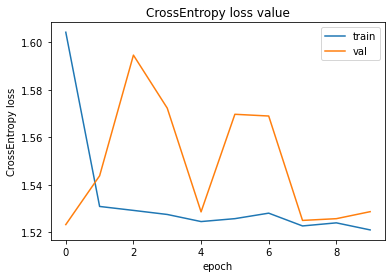

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

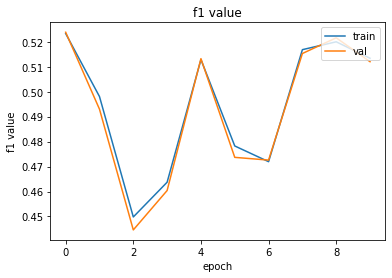

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

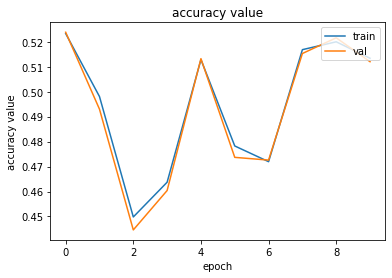

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5238, device='cuda:0')

### Эксперименты: нет дропаута, kernel_size=3

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[3], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:18,  2.31s/it]

Train loss: 1.6830568462610245


16it [00:38,  2.38s/it]

Train loss: 1.6336253508925438


24it [00:56,  2.34s/it]

Train loss: 1.6020312905311584


32it [01:15,  2.33s/it]

Train loss: 1.5855296961963177


40it [01:34,  2.35s/it]

Train loss: 1.5743714839220047


42it [01:37,  2.33s/it]



Evaluating on train...


8it [00:14,  1.82s/it]

Val loss: 1.529929131269455, Val f1: 0.510498046875, Val accuracy: 0.510498046875


16it [00:30,  1.90s/it]

Val loss: 1.5281043127179146, Val f1: 0.512939453125, Val accuracy: 0.512939453125


24it [00:45,  1.88s/it]

Val loss: 1.5270148764053981, Val f1: 0.5140787959098816, Val accuracy: 0.5140787959098816


32it [01:00,  1.85s/it]

Val loss: 1.5272016413509846, Val f1: 0.51409912109375, Val accuracy: 0.51409912109375


40it [01:15,  1.88s/it]

Val loss: 1.5276673942804337, Val f1: 0.5135254263877869, Val accuracy: 0.5135254263877869


42it [01:17,  1.85s/it]



Evaluating on test...


1it [00:01,  1.92s/it]

Val loss: 1.5320700407028198, Val f1: 0.513671875, Val accuracy: 0.513671875


2it [00:03,  1.92s/it]

Val loss: 1.5113471150398254, Val f1: 0.533203125, Val accuracy: 0.533203125


3it [00:05,  1.87s/it]

Val loss: 1.5320905447006226, Val f1: 0.509765625, Val accuracy: 0.509765625


4it [00:07,  1.88s/it]

Val loss: 1.5334163308143616, Val f1: 0.50732421875, Val accuracy: 0.50732421875


5it [00:08,  1.74s/it]


Val loss: 1.5330639600753784, Val f1: 0.5081849694252014, Val accuracy: 0.5081849694252014

starting Epoch 1
Training...


8it [00:18,  2.29s/it]

Train loss: 1.555929183959961


16it [00:37,  2.37s/it]

Train loss: 1.5413373336195946


24it [00:56,  2.35s/it]

Train loss: 1.5323877334594727


32it [01:15,  2.33s/it]

Train loss: 1.5297125726938248


40it [01:34,  2.40s/it]

Train loss: 1.5299750536680221


42it [01:37,  2.33s/it]



Evaluating on train...


8it [00:14,  1.81s/it]

Val loss: 1.5231575518846512, Val f1: 0.513671875, Val accuracy: 0.513671875


16it [00:30,  1.90s/it]

Val loss: 1.5220159888267517, Val f1: 0.5166015625, Val accuracy: 0.5166015625


24it [00:45,  1.93s/it]

Val loss: 1.520455131928126, Val f1: 0.5181478261947632, Val accuracy: 0.5181478261947632


32it [01:00,  1.85s/it]

Val loss: 1.5209106728434563, Val f1: 0.51800537109375, Val accuracy: 0.51800537109375


40it [01:16,  1.91s/it]

Val loss: 1.5215425401926042, Val f1: 0.5171875357627869, Val accuracy: 0.5171875357627869


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.90s/it]

Val loss: 1.52784264087677, Val f1: 0.5234375, Val accuracy: 0.5234375


2it [00:03,  1.91s/it]

Val loss: 1.5048993229866028, Val f1: 0.5380859375, Val accuracy: 0.5380859375


3it [00:05,  1.89s/it]

Val loss: 1.5247278213500977, Val f1: 0.5149739980697632, Val accuracy: 0.5149739980697632


4it [00:07,  1.89s/it]

Val loss: 1.5243433117866516, Val f1: 0.51171875, Val accuracy: 0.51171875


5it [00:08,  1.74s/it]


Val loss: 1.5254366636276244, Val f1: 0.5117005705833435, Val accuracy: 0.5117005705833435

starting Epoch 2
Training...


8it [00:18,  2.30s/it]

Train loss: 1.5361130684614182


16it [00:37,  2.39s/it]

Train loss: 1.5297872424125671


24it [00:56,  2.35s/it]

Train loss: 1.5270636131366093


32it [01:15,  2.36s/it]

Train loss: 1.5277311988174915


40it [01:34,  2.35s/it]

Train loss: 1.5283473491668702


42it [01:37,  2.32s/it]



Evaluating on train...


8it [00:15,  1.88s/it]

Val loss: 1.5246088653802872, Val f1: 0.512939453125, Val accuracy: 0.512939453125


16it [00:30,  1.90s/it]

Val loss: 1.5266737267374992, Val f1: 0.5111083984375, Val accuracy: 0.5111083984375


24it [00:46,  1.94s/it]

Val loss: 1.5258609503507614, Val f1: 0.51171875, Val accuracy: 0.51171875


32it [01:01,  1.88s/it]

Val loss: 1.5251604989171028, Val f1: 0.5130615234375, Val accuracy: 0.5130615234375


40it [01:16,  1.89s/it]

Val loss: 1.525915202498436, Val f1: 0.512451171875, Val accuracy: 0.512451171875


42it [01:19,  1.89s/it]



Evaluating on test...


1it [00:01,  1.83s/it]

Val loss: 1.5292696952819824, Val f1: 0.515625, Val accuracy: 0.515625


2it [00:03,  1.85s/it]

Val loss: 1.5069225430488586, Val f1: 0.5361328125, Val accuracy: 0.5361328125


3it [00:05,  1.83s/it]

Val loss: 1.5254541635513306, Val f1: 0.5149739980697632, Val accuracy: 0.5149739980697632


4it [00:07,  1.87s/it]

Val loss: 1.523851066827774, Val f1: 0.515625, Val accuracy: 0.515625


5it [00:08,  1.71s/it]


Val loss: 1.5263763189315795, Val f1: 0.5128322243690491, Val accuracy: 0.5128322243690491

starting Epoch 3
Training...


8it [00:18,  2.31s/it]

Train loss: 1.5237606763839722


16it [00:37,  2.39s/it]

Train loss: 1.5227755978703499


24it [00:57,  2.38s/it]

Train loss: 1.5199391841888428


32it [01:15,  2.36s/it]

Train loss: 1.5207455232739449


40it [01:34,  2.34s/it]

Train loss: 1.5224491357803345


42it [01:37,  2.33s/it]



Evaluating on train...


8it [00:14,  1.85s/it]

Val loss: 1.546399250626564, Val f1: 0.493896484375, Val accuracy: 0.493896484375


16it [00:30,  1.92s/it]

Val loss: 1.5508640930056572, Val f1: 0.4891357421875, Val accuracy: 0.4891357421875


24it [00:45,  1.89s/it]

Val loss: 1.5518357306718826, Val f1: 0.4874674677848816, Val accuracy: 0.4874674677848816


32it [01:00,  1.88s/it]

Val loss: 1.5496635138988495, Val f1: 0.4901123046875, Val accuracy: 0.4901123046875


40it [01:16,  1.91s/it]

Val loss: 1.5493121951818467, Val f1: 0.49018555879592896, Val accuracy: 0.49018555879592896


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.90s/it]

Val loss: 1.5672204494476318, Val f1: 0.4765625, Val accuracy: 0.4765625


2it [00:03,  1.91s/it]

Val loss: 1.5408821105957031, Val f1: 0.501953125, Val accuracy: 0.501953125


3it [00:05,  1.86s/it]

Val loss: 1.5535176595052083, Val f1: 0.48828125, Val accuracy: 0.48828125


4it [00:07,  1.89s/it]

Val loss: 1.551227480173111, Val f1: 0.4873046875, Val accuracy: 0.4873046875


5it [00:08,  1.73s/it]


Val loss: 1.5508842706680297, Val f1: 0.4888470768928528, Val accuracy: 0.4888470768928528

starting Epoch 4
Training...


8it [00:18,  2.30s/it]

Train loss: 1.5268599092960358


16it [00:38,  2.42s/it]

Train loss: 1.5239132195711136


24it [00:57,  2.36s/it]

Train loss: 1.5195382634798686


32it [01:15,  2.34s/it]

Train loss: 1.521724209189415


40it [01:35,  2.42s/it]

Train loss: 1.5215949445962906


42it [01:38,  2.34s/it]



Evaluating on train...


8it [00:15,  1.86s/it]

Val loss: 1.525659203529358, Val f1: 0.51416015625, Val accuracy: 0.51416015625


16it [00:30,  1.91s/it]

Val loss: 1.5265611484646797, Val f1: 0.5146484375, Val accuracy: 0.5146484375


24it [00:46,  1.94s/it]

Val loss: 1.525379404425621, Val f1: 0.5146484375, Val accuracy: 0.5146484375


32it [01:01,  1.86s/it]

Val loss: 1.5248829275369644, Val f1: 0.515625, Val accuracy: 0.515625


40it [01:16,  1.89s/it]

Val loss: 1.525413766503334, Val f1: 0.514599621295929, Val accuracy: 0.514599621295929


42it [01:19,  1.89s/it]



Evaluating on test...


1it [00:01,  1.87s/it]

Val loss: 1.5307728052139282, Val f1: 0.515625, Val accuracy: 0.515625


2it [00:03,  1.87s/it]

Val loss: 1.5086161494255066, Val f1: 0.537109375, Val accuracy: 0.537109375


3it [00:05,  1.83s/it]

Val loss: 1.5276801188786824, Val f1: 0.515625, Val accuracy: 0.515625


4it [00:07,  1.85s/it]

Val loss: 1.5275699198246002, Val f1: 0.51220703125, Val accuracy: 0.51220703125


5it [00:08,  1.70s/it]


Val loss: 1.528619909286499, Val f1: 0.5107623338699341, Val accuracy: 0.5107623338699341

starting Epoch 5
Training...


8it [00:18,  2.28s/it]

Train loss: 1.5243007391691208


16it [00:37,  2.37s/it]

Train loss: 1.531702682375908


24it [00:56,  2.35s/it]

Train loss: 1.524453416466713


32it [01:15,  2.31s/it]

Train loss: 1.524433922022581


40it [01:33,  2.36s/it]

Train loss: 1.523345223069191


42it [01:37,  2.31s/it]



Evaluating on train...


8it [00:14,  1.82s/it]

Val loss: 1.5171136260032654, Val f1: 0.5205078125, Val accuracy: 0.5205078125


16it [00:29,  1.88s/it]

Val loss: 1.5182899832725525, Val f1: 0.5211181640625, Val accuracy: 0.5211181640625


24it [00:44,  1.85s/it]

Val loss: 1.5162034928798676, Val f1: 0.5230306386947632, Val accuracy: 0.5230306386947632


32it [00:59,  1.83s/it]

Val loss: 1.5164337940514088, Val f1: 0.52301025390625, Val accuracy: 0.52301025390625


40it [01:14,  1.86s/it]

Val loss: 1.5171053647994994, Val f1: 0.522216796875, Val accuracy: 0.522216796875


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5206092596054077, Val f1: 0.53125, Val accuracy: 0.53125


2it [00:03,  1.88s/it]

Val loss: 1.4997824430465698, Val f1: 0.548828125, Val accuracy: 0.548828125


3it [00:05,  1.85s/it]

Val loss: 1.5183282295862834, Val f1: 0.52734375, Val accuracy: 0.52734375


4it [00:07,  1.87s/it]

Val loss: 1.5155877768993378, Val f1: 0.525390625, Val accuracy: 0.525390625


5it [00:08,  1.71s/it]


Val loss: 1.5182743310928344, Val f1: 0.5219736099243164, Val accuracy: 0.5219736099243164

starting Epoch 6
Training...


8it [00:18,  2.26s/it]

Train loss: 1.5247723460197449


16it [00:37,  2.34s/it]

Train loss: 1.5234423130750656


24it [00:55,  2.33s/it]

Train loss: 1.5184433509906132


32it [01:14,  2.29s/it]

Train loss: 1.5211657546460629


40it [01:33,  2.35s/it]

Train loss: 1.52065711915493


42it [01:36,  2.29s/it]



Evaluating on train...


8it [00:14,  1.79s/it]

Val loss: 1.591350108385086, Val f1: 0.450439453125, Val accuracy: 0.450439453125


16it [00:29,  1.87s/it]

Val loss: 1.5952029153704643, Val f1: 0.4461669921875, Val accuracy: 0.4461669921875


24it [00:44,  1.82s/it]

Val loss: 1.596162607272466, Val f1: 0.4447428584098816, Val accuracy: 0.4447428584098816


32it [00:59,  1.83s/it]

Val loss: 1.5935296937823296, Val f1: 0.44915771484375, Val accuracy: 0.44915771484375


40it [01:14,  1.90s/it]

Val loss: 1.5922063559293747, Val f1: 0.450439453125, Val accuracy: 0.450439453125


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.96s/it]

Val loss: 1.6112715005874634, Val f1: 0.443359375, Val accuracy: 0.443359375


2it [00:03,  1.95s/it]

Val loss: 1.5931712985038757, Val f1: 0.455078125, Val accuracy: 0.455078125


3it [00:05,  1.88s/it]

Val loss: 1.6011805534362793, Val f1: 0.4446614682674408, Val accuracy: 0.4446614682674408


4it [00:07,  1.89s/it]

Val loss: 1.597078800201416, Val f1: 0.44580078125, Val accuracy: 0.44580078125


5it [00:08,  1.75s/it]


Val loss: 1.5970998287200928, Val f1: 0.4443482458591461, Val accuracy: 0.4443482458591461

starting Epoch 7
Training...


8it [00:18,  2.28s/it]

Train loss: 1.5508608520030975


16it [00:37,  2.34s/it]

Train loss: 1.537325382232666


24it [00:56,  2.33s/it]

Train loss: 1.5289132793744404


32it [01:14,  2.31s/it]

Train loss: 1.5268648006021976


40it [01:33,  2.33s/it]

Train loss: 1.526827797293663


42it [01:36,  2.30s/it]



Evaluating on train...


8it [00:14,  1.79s/it]

Val loss: 1.5160316824913025, Val f1: 0.524658203125, Val accuracy: 0.524658203125


16it [00:29,  1.87s/it]

Val loss: 1.5154371410608292, Val f1: 0.5274658203125, Val accuracy: 0.5274658203125


24it [00:44,  1.85s/it]

Val loss: 1.5124783714612324, Val f1: 0.531005859375, Val accuracy: 0.531005859375


32it [00:59,  1.83s/it]

Val loss: 1.5137066543102264, Val f1: 0.52935791015625, Val accuracy: 0.52935791015625


40it [01:14,  1.85s/it]

Val loss: 1.5144758582115174, Val f1: 0.5281738638877869, Val accuracy: 0.5281738638877869


42it [01:16,  1.82s/it]



Evaluating on test...


1it [00:01,  1.83s/it]

Val loss: 1.5201224088668823, Val f1: 0.53125, Val accuracy: 0.53125


2it [00:03,  1.86s/it]

Val loss: 1.497944176197052, Val f1: 0.55078125, Val accuracy: 0.55078125


3it [00:05,  1.83s/it]

Val loss: 1.5159159898757935, Val f1: 0.529296875, Val accuracy: 0.529296875


4it [00:07,  1.84s/it]

Val loss: 1.512834519147873, Val f1: 0.529296875, Val accuracy: 0.529296875


5it [00:08,  1.69s/it]


Val loss: 1.5156095504760743, Val f1: 0.5270919799804688, Val accuracy: 0.5270919799804688

starting Epoch 8
Training...


8it [00:18,  2.26s/it]

Train loss: 1.5387875735759735


16it [00:37,  2.33s/it]

Train loss: 1.5280989184975624


24it [00:55,  2.32s/it]

Train loss: 1.522298072775205


32it [01:14,  2.29s/it]

Train loss: 1.5215885527431965


40it [01:32,  2.34s/it]

Train loss: 1.5211854487657548


42it [01:36,  2.29s/it]



Evaluating on train...


8it [00:14,  1.79s/it]

Val loss: 1.523799791932106, Val f1: 0.5205078125, Val accuracy: 0.5205078125


16it [00:29,  1.86s/it]

Val loss: 1.5267140045762062, Val f1: 0.5181884765625, Val accuracy: 0.5181884765625


24it [00:44,  1.86s/it]

Val loss: 1.5255208661158879, Val f1: 0.519775390625, Val accuracy: 0.519775390625


32it [00:59,  1.86s/it]

Val loss: 1.5245731063187122, Val f1: 0.5211181640625, Val accuracy: 0.5211181640625


40it [01:14,  1.88s/it]

Val loss: 1.5250161319971085, Val f1: 0.5198730826377869, Val accuracy: 0.5198730826377869


42it [01:17,  1.83s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.5284714698791504, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:03,  1.87s/it]

Val loss: 1.508459985256195, Val f1: 0.5390625, Val accuracy: 0.5390625


3it [00:05,  1.84s/it]

Val loss: 1.525390346844991, Val f1: 0.5169271230697632, Val accuracy: 0.5169271230697632


4it [00:07,  1.86s/it]

Val loss: 1.5231151282787323, Val f1: 0.517578125, Val accuracy: 0.517578125


5it [00:08,  1.71s/it]


Val loss: 1.5255983352661133, Val f1: 0.5157236456871033, Val accuracy: 0.5157236456871033

starting Epoch 9
Training...


8it [00:18,  2.34s/it]

Train loss: 1.5193025022745132


16it [00:38,  2.38s/it]

Train loss: 1.5195983052253723


24it [00:56,  2.34s/it]

Train loss: 1.5153646071751912


32it [01:15,  2.32s/it]

Train loss: 1.5301002338528633


40it [01:34,  2.34s/it]

Train loss: 1.5331549733877181


42it [01:37,  2.32s/it]



Evaluating on train...


8it [00:14,  1.80s/it]

Val loss: 1.5251181721687317, Val f1: 0.52392578125, Val accuracy: 0.52392578125


16it [00:29,  1.85s/it]

Val loss: 1.5266151055693626, Val f1: 0.5242919921875, Val accuracy: 0.5242919921875


24it [00:44,  1.86s/it]

Val loss: 1.524999588727951, Val f1: 0.52685546875, Val accuracy: 0.52685546875


32it [00:59,  1.82s/it]

Val loss: 1.5248604342341423, Val f1: 0.5264892578125, Val accuracy: 0.5264892578125


40it [01:14,  1.86s/it]

Val loss: 1.5249097377061844, Val f1: 0.526806652545929, Val accuracy: 0.526806652545929


42it [01:16,  1.82s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.532768726348877, Val f1: 0.53515625, Val accuracy: 0.53515625


2it [00:03,  1.86s/it]

Val loss: 1.5150449872016907, Val f1: 0.5458984375, Val accuracy: 0.5458984375


3it [00:05,  1.84s/it]

Val loss: 1.528844992319743, Val f1: 0.5260416865348816, Val accuracy: 0.5260416865348816


4it [00:07,  1.85s/it]

Val loss: 1.5258966982364655, Val f1: 0.525390625, Val accuracy: 0.525390625


5it [00:08,  1.69s/it]

Val loss: 1.5279296159744262, Val f1: 0.5239669680595398, Val accuracy: 0.5239669680595398


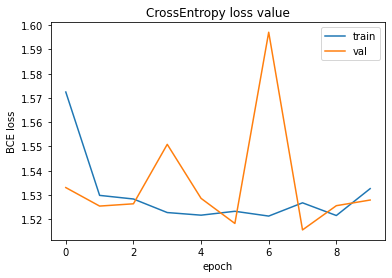

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

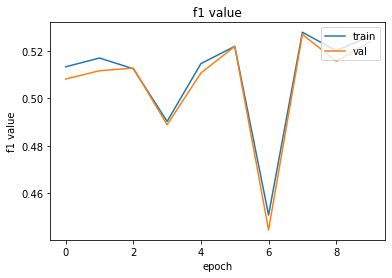

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

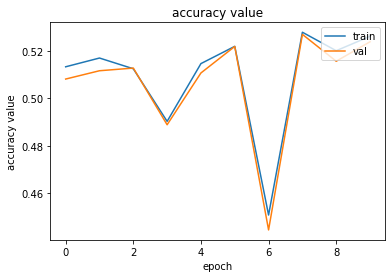

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5271, device='cuda:0')

### Эксперименты: нет дропаута, kernel_size=4

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:18,  2.33s/it]

Train loss: 1.720320612192154


16it [00:38,  2.40s/it]

Train loss: 1.6748306453227997


24it [00:57,  2.39s/it]

Train loss: 1.6393841058015823


32it [01:16,  2.36s/it]

Train loss: 1.6160819493234158


40it [01:35,  2.43s/it]

Train loss: 1.601171115040779


42it [01:38,  2.36s/it]



Evaluating on train...


8it [00:14,  1.83s/it]

Val loss: 1.559295192360878, Val f1: 0.48291015625, Val accuracy: 0.48291015625


16it [00:30,  1.94s/it]

Val loss: 1.5626971945166588, Val f1: 0.4801025390625, Val accuracy: 0.4801025390625


24it [00:45,  1.89s/it]

Val loss: 1.5633584608634312, Val f1: 0.4803059995174408, Val accuracy: 0.4803059995174408


32it [01:00,  1.86s/it]

Val loss: 1.5614076405763626, Val f1: 0.482421875, Val accuracy: 0.482421875


40it [01:15,  1.91s/it]

Val loss: 1.560800838470459, Val f1: 0.4830078184604645, Val accuracy: 0.4830078184604645


42it [01:18,  1.86s/it]



Evaluating on test...


1it [00:01,  1.83s/it]

Val loss: 1.5666358470916748, Val f1: 0.478515625, Val accuracy: 0.478515625


2it [00:03,  1.87s/it]

Val loss: 1.5486142039299011, Val f1: 0.4931640625, Val accuracy: 0.4931640625


3it [00:05,  1.84s/it]

Val loss: 1.5601670344670613, Val f1: 0.4817708432674408, Val accuracy: 0.4817708432674408


4it [00:07,  1.85s/it]

Val loss: 1.5580775141716003, Val f1: 0.4853515625, Val accuracy: 0.4853515625


5it [00:08,  1.70s/it]


Val loss: 1.559823226928711, Val f1: 0.47931113839149475, Val accuracy: 0.47931113839149475

starting Epoch 1
Training...


8it [00:18,  2.31s/it]

Train loss: 1.535277932882309


16it [00:38,  2.38s/it]

Train loss: 1.5380618274211884


24it [00:57,  2.39s/it]

Train loss: 1.5325678537289302


32it [01:16,  2.35s/it]

Train loss: 1.530968315899372


40it [01:35,  2.37s/it]

Train loss: 1.5311397343873978


42it [01:38,  2.34s/it]



Evaluating on train...


8it [00:14,  1.82s/it]

Val loss: 1.5211997628211975, Val f1: 0.519775390625, Val accuracy: 0.519775390625


16it [00:30,  1.91s/it]

Val loss: 1.5210994556546211, Val f1: 0.5213623046875, Val accuracy: 0.5213623046875


24it [00:45,  1.87s/it]

Val loss: 1.5195258458455403, Val f1: 0.5244954824447632, Val accuracy: 0.5244954824447632


32it [01:00,  1.85s/it]

Val loss: 1.5200164951384068, Val f1: 0.5234375, Val accuracy: 0.5234375


40it [01:15,  1.89s/it]

Val loss: 1.5211019307374953, Val f1: 0.521923840045929, Val accuracy: 0.521923840045929


42it [01:18,  1.86s/it]



Evaluating on test...


1it [00:01,  1.85s/it]

Val loss: 1.526008129119873, Val f1: 0.5234375, Val accuracy: 0.5234375


2it [00:03,  1.90s/it]

Val loss: 1.504352629184723, Val f1: 0.54296875, Val accuracy: 0.54296875


3it [00:05,  1.87s/it]

Val loss: 1.5228373606999714, Val f1: 0.5201823115348816, Val accuracy: 0.5201823115348816


4it [00:07,  1.88s/it]

Val loss: 1.520717591047287, Val f1: 0.521484375, Val accuracy: 0.521484375


5it [00:08,  1.72s/it]


Val loss: 1.5220917224884034, Val f1: 0.5188485980033875, Val accuracy: 0.5188485980033875

starting Epoch 2
Training...


8it [00:18,  2.34s/it]

Train loss: 1.5304486900568008


16it [00:38,  2.40s/it]

Train loss: 1.527613028883934


24it [00:57,  2.39s/it]

Train loss: 1.5234020054340363


32it [01:16,  2.36s/it]

Train loss: 1.5270999558269978


40it [01:35,  2.38s/it]

Train loss: 1.5272848337888718


42it [01:38,  2.35s/it]



Evaluating on train...


8it [00:14,  1.80s/it]

Val loss: 1.5277738124132156, Val f1: 0.515625, Val accuracy: 0.515625


16it [00:29,  1.88s/it]

Val loss: 1.529895469546318, Val f1: 0.514892578125, Val accuracy: 0.514892578125


24it [00:44,  1.86s/it]

Val loss: 1.5289094597101212, Val f1: 0.5170084834098816, Val accuracy: 0.5170084834098816


32it [00:59,  1.83s/it]

Val loss: 1.5283613465726376, Val f1: 0.517822265625, Val accuracy: 0.517822265625


40it [01:14,  1.85s/it]

Val loss: 1.528776291012764, Val f1: 0.516894519329071, Val accuracy: 0.516894519329071


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5298281908035278, Val f1: 0.525390625, Val accuracy: 0.525390625


2it [00:03,  1.88s/it]

Val loss: 1.511842131614685, Val f1: 0.5419921875, Val accuracy: 0.5419921875


3it [00:05,  1.85s/it]

Val loss: 1.5285998582839966, Val f1: 0.5201823115348816, Val accuracy: 0.5201823115348816


4it [00:07,  1.88s/it]

Val loss: 1.527017205953598, Val f1: 0.51953125, Val accuracy: 0.51953125


5it [00:08,  1.72s/it]


Val loss: 1.5289621353149414, Val f1: 0.5152928233146667, Val accuracy: 0.5152928233146667

starting Epoch 3
Training...


8it [00:19,  2.36s/it]

Train loss: 1.5245438665151596


16it [00:38,  2.43s/it]

Train loss: 1.5289873778820038


24it [00:58,  2.40s/it]

Train loss: 1.5244547178347905


32it [01:17,  2.36s/it]

Train loss: 1.5240109488368034


40it [01:36,  2.40s/it]

Train loss: 1.5234755784273148


42it [01:39,  2.37s/it]



Evaluating on train...


8it [00:14,  1.79s/it]

Val loss: 1.5189529955387115, Val f1: 0.519287109375, Val accuracy: 0.519287109375


16it [00:29,  1.87s/it]

Val loss: 1.518689937889576, Val f1: 0.521484375, Val accuracy: 0.521484375


24it [00:44,  1.84s/it]

Val loss: 1.5164849956830342, Val f1: 0.52490234375, Val accuracy: 0.52490234375


32it [00:59,  1.85s/it]

Val loss: 1.516990303993225, Val f1: 0.52423095703125, Val accuracy: 0.52423095703125


40it [01:14,  1.86s/it]

Val loss: 1.5177637845277787, Val f1: 0.522998034954071, Val accuracy: 0.522998034954071


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.5159565210342407, Val f1: 0.529296875, Val accuracy: 0.529296875


2it [00:03,  1.86s/it]

Val loss: 1.4988505840301514, Val f1: 0.546875, Val accuracy: 0.546875


3it [00:05,  1.84s/it]

Val loss: 1.5177746216456096, Val f1: 0.5247396230697632, Val accuracy: 0.5247396230697632


4it [00:07,  1.85s/it]

Val loss: 1.5168171525001526, Val f1: 0.52392578125, Val accuracy: 0.52392578125


5it [00:08,  1.70s/it]


Val loss: 1.519303846359253, Val f1: 0.5188084244728088, Val accuracy: 0.5188084244728088

starting Epoch 4
Training...


8it [00:18,  2.33s/it]

Train loss: 1.5343211740255356


16it [00:38,  2.42s/it]

Train loss: 1.5273877829313278


24it [00:57,  2.39s/it]

Train loss: 1.5208229670921962


32it [01:16,  2.36s/it]

Train loss: 1.521324846893549


40it [01:35,  2.38s/it]

Train loss: 1.5212574183940888


42it [01:38,  2.35s/it]



Evaluating on train...


8it [00:14,  1.79s/it]

Val loss: 1.5189507901668549, Val f1: 0.521728515625, Val accuracy: 0.521728515625


16it [00:29,  1.88s/it]

Val loss: 1.5168832838535309, Val f1: 0.5242919921875, Val accuracy: 0.5242919921875


24it [00:44,  1.87s/it]

Val loss: 1.5141525715589523, Val f1: 0.5267741084098816, Val accuracy: 0.5267741084098816


32it [00:59,  1.83s/it]

Val loss: 1.5152040123939514, Val f1: 0.5262451171875, Val accuracy: 0.5262451171875


40it [01:14,  1.89s/it]

Val loss: 1.5157106310129165, Val f1: 0.5254883170127869, Val accuracy: 0.5254883170127869


42it [01:16,  1.83s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5204265117645264, Val f1: 0.52734375, Val accuracy: 0.52734375


2it [00:03,  1.87s/it]

Val loss: 1.5004647374153137, Val f1: 0.546875, Val accuracy: 0.546875


3it [00:05,  1.85s/it]

Val loss: 1.52000896135966, Val f1: 0.5240885615348816, Val accuracy: 0.5240885615348816


4it [00:07,  1.87s/it]

Val loss: 1.5205877721309662, Val f1: 0.52099609375, Val accuracy: 0.52099609375


5it [00:08,  1.71s/it]


Val loss: 1.5223466634750367, Val f1: 0.517129123210907, Val accuracy: 0.517129123210907

starting Epoch 5
Training...


8it [00:18,  2.34s/it]

Train loss: 1.5264548063278198


16it [00:38,  2.39s/it]

Train loss: 1.5219993442296982


24it [00:57,  2.40s/it]

Train loss: 1.5164294044176738


32it [01:16,  2.36s/it]

Train loss: 1.523709338158369


40it [01:35,  2.42s/it]

Train loss: 1.5237457215785981


42it [01:39,  2.36s/it]



Evaluating on train...


8it [00:15,  1.88s/it]

Val loss: 1.5274191796779633, Val f1: 0.5087890625, Val accuracy: 0.5087890625


16it [00:30,  1.90s/it]

Val loss: 1.5246386677026749, Val f1: 0.5126953125, Val accuracy: 0.5126953125


24it [00:45,  1.87s/it]

Val loss: 1.5219244708617528, Val f1: 0.5159505605697632, Val accuracy: 0.5159505605697632


32it [01:00,  1.86s/it]

Val loss: 1.5229496099054813, Val f1: 0.51580810546875, Val accuracy: 0.51580810546875


40it [01:15,  1.89s/it]

Val loss: 1.5233308017253875, Val f1: 0.515332043170929, Val accuracy: 0.515332043170929


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.85s/it]

Val loss: 1.533227562904358, Val f1: 0.509765625, Val accuracy: 0.509765625


2it [00:03,  1.90s/it]

Val loss: 1.5085089802742004, Val f1: 0.533203125, Val accuracy: 0.533203125


3it [00:05,  1.87s/it]

Val loss: 1.529545505841573, Val f1: 0.5110677480697632, Val accuracy: 0.5110677480697632


4it [00:07,  1.89s/it]

Val loss: 1.5323207378387451, Val f1: 0.50341796875, Val accuracy: 0.50341796875


5it [00:08,  1.73s/it]


Val loss: 1.5323005676269532, Val f1: 0.5037310719490051, Val accuracy: 0.5037310719490051

starting Epoch 6
Training...


8it [00:19,  2.37s/it]

Train loss: 1.5926665514707565


16it [00:38,  2.47s/it]

Train loss: 1.5552366599440575


24it [00:58,  2.44s/it]

Train loss: 1.5413959721724193


32it [01:17,  2.39s/it]

Train loss: 1.550313450396061


40it [01:37,  2.44s/it]

Train loss: 1.548245260119438


42it [01:40,  2.39s/it]



Evaluating on train...


8it [00:14,  1.84s/it]

Val loss: 1.526199460029602, Val f1: 0.522705078125, Val accuracy: 0.522705078125


16it [00:30,  1.89s/it]

Val loss: 1.5269894003868103, Val f1: 0.523193359375, Val accuracy: 0.523193359375


24it [00:45,  1.86s/it]

Val loss: 1.525168314576149, Val f1: 0.5249837636947632, Val accuracy: 0.5249837636947632


32it [01:00,  1.85s/it]

Val loss: 1.525005653500557, Val f1: 0.52496337890625, Val accuracy: 0.52496337890625


40it [01:15,  1.89s/it]

Val loss: 1.5258162766695023, Val f1: 0.523632824420929, Val accuracy: 0.523632824420929


42it [01:18,  1.86s/it]



Evaluating on test...


1it [00:01,  1.87s/it]

Val loss: 1.529464602470398, Val f1: 0.533203125, Val accuracy: 0.533203125


2it [00:03,  1.88s/it]

Val loss: 1.512260615825653, Val f1: 0.5478515625, Val accuracy: 0.5478515625


3it [00:05,  1.84s/it]

Val loss: 1.5284583965937297, Val f1: 0.5260416865348816, Val accuracy: 0.5260416865348816


4it [00:07,  1.88s/it]

Val loss: 1.5264663398265839, Val f1: 0.52294921875, Val accuracy: 0.52294921875


5it [00:08,  1.71s/it]


Val loss: 1.5293407678604125, Val f1: 0.5186915993690491, Val accuracy: 0.5186915993690491

starting Epoch 7
Training...


8it [00:19,  2.39s/it]

Train loss: 1.5293648093938828


16it [00:39,  2.47s/it]

Train loss: 1.5205023065209389


24it [00:58,  2.46s/it]

Train loss: 1.515139604608218


32it [01:17,  2.38s/it]

Train loss: 1.515539489686489


40it [01:37,  2.40s/it]

Train loss: 1.5094587534666062


42it [01:40,  2.39s/it]



Evaluating on train...


8it [00:14,  1.83s/it]

Val loss: 1.4663008153438568, Val f1: 0.578857421875, Val accuracy: 0.578857421875


16it [00:30,  1.92s/it]

Val loss: 1.4666690900921822, Val f1: 0.5787353515625, Val accuracy: 0.5787353515625


24it [00:45,  1.89s/it]

Val loss: 1.4620737830797832, Val f1: 0.5828450918197632, Val accuracy: 0.5828450918197632


32it [01:00,  1.86s/it]

Val loss: 1.4624375328421593, Val f1: 0.58270263671875, Val accuracy: 0.58270263671875


40it [01:15,  1.88s/it]

Val loss: 1.460892641544342, Val f1: 0.5843750238418579, Val accuracy: 0.5843750238418579


42it [01:18,  1.86s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.466819405555725, Val f1: 0.587890625, Val accuracy: 0.587890625


2it [00:03,  1.90s/it]

Val loss: 1.4564970135688782, Val f1: 0.5927734375, Val accuracy: 0.5927734375


3it [00:05,  1.86s/it]

Val loss: 1.4712258577346802, Val f1: 0.5774739980697632, Val accuracy: 0.5774739980697632


4it [00:07,  1.87s/it]

Val loss: 1.4664398431777954, Val f1: 0.580078125, Val accuracy: 0.580078125


5it [00:08,  1.72s/it]


Val loss: 1.4687459468841553, Val f1: 0.5763549208641052, Val accuracy: 0.5763549208641052

starting Epoch 8
Training...


8it [00:18,  2.34s/it]

Train loss: 1.4568132162094116


16it [00:38,  2.43s/it]

Train loss: 1.4739584848284721


24it [00:57,  2.42s/it]

Train loss: 1.4667559067408245


32it [01:17,  2.38s/it]

Train loss: 1.4581828266382217


40it [01:36,  2.42s/it]

Train loss: 1.4506165534257889


42it [01:39,  2.38s/it]



Evaluating on train...


8it [00:14,  1.84s/it]

Val loss: 1.4587895572185516, Val f1: 0.588623046875, Val accuracy: 0.588623046875


16it [00:30,  1.95s/it]

Val loss: 1.4581784829497337, Val f1: 0.5877685546875, Val accuracy: 0.5877685546875


24it [00:45,  1.88s/it]

Val loss: 1.4513982981443405, Val f1: 0.59375, Val accuracy: 0.59375


32it [01:00,  1.89s/it]

Val loss: 1.4503007009625435, Val f1: 0.5947265625, Val accuracy: 0.5947265625


40it [01:16,  1.87s/it]

Val loss: 1.4474011093378067, Val f1: 0.598193347454071, Val accuracy: 0.598193347454071


42it [01:18,  1.87s/it]



Evaluating on test...


1it [00:01,  1.87s/it]

Val loss: 1.4676593542099, Val f1: 0.58203125, Val accuracy: 0.58203125


2it [00:03,  1.89s/it]

Val loss: 1.4534807801246643, Val f1: 0.5947265625, Val accuracy: 0.5947265625


3it [00:05,  1.86s/it]

Val loss: 1.4653511842091878, Val f1: 0.5813802480697632, Val accuracy: 0.5813802480697632


4it [00:07,  1.90s/it]

Val loss: 1.4640948474407196, Val f1: 0.58056640625, Val accuracy: 0.58056640625


5it [00:08,  1.74s/it]


Val loss: 1.4679636240005494, Val f1: 0.5767455101013184, Val accuracy: 0.5767455101013184

starting Epoch 9
Training...


8it [00:18,  2.34s/it]

Train loss: 1.4447470605373383


16it [00:38,  2.43s/it]

Train loss: 1.441005289554596


24it [00:57,  2.38s/it]

Train loss: 1.4295780559380848


32it [01:16,  2.37s/it]

Train loss: 1.4274784065783024


40it [01:36,  2.42s/it]

Train loss: 1.4247384190559387


42it [01:39,  2.37s/it]



Evaluating on train...


8it [00:14,  1.82s/it]

Val loss: 1.4474292546510696, Val f1: 0.5947265625, Val accuracy: 0.5947265625


16it [00:30,  1.89s/it]

Val loss: 1.4437638595700264, Val f1: 0.59814453125, Val accuracy: 0.59814453125


24it [00:45,  1.89s/it]

Val loss: 1.4374259461959202, Val f1: 0.6048991084098816, Val accuracy: 0.6048991084098816


32it [01:00,  1.84s/it]

Val loss: 1.4366645030677319, Val f1: 0.60577392578125, Val accuracy: 0.60577392578125


40it [01:15,  1.89s/it]

Val loss: 1.4326223582029343, Val f1: 0.609912097454071, Val accuracy: 0.609912097454071


42it [01:17,  1.86s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.4437566995620728, Val f1: 0.603515625, Val accuracy: 0.603515625


2it [00:03,  1.88s/it]

Val loss: 1.434491753578186, Val f1: 0.609375, Val accuracy: 0.609375


3it [00:05,  1.85s/it]

Val loss: 1.4503048658370972, Val f1: 0.5911458730697632, Val accuracy: 0.5911458730697632


4it [00:07,  1.86s/it]

Val loss: 1.451251894235611, Val f1: 0.587890625, Val accuracy: 0.587890625


5it [00:08,  1.71s/it]

Val loss: 1.44875648021698, Val f1: 0.5899138450622559, Val accuracy: 0.5899138450622559


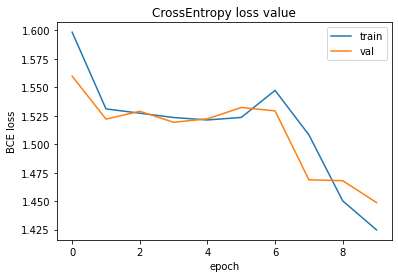

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

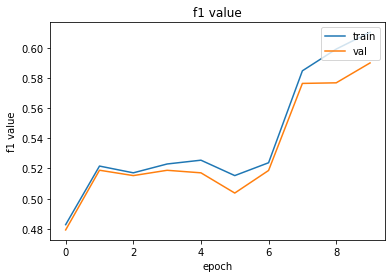

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

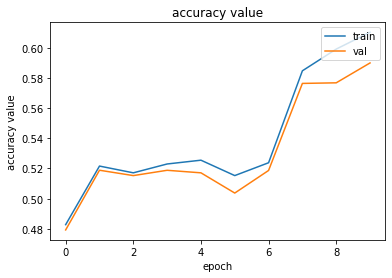

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5899, device='cuda:0')

### Эксперименты: без дропаута, kernel_size=2, 3

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[2, 3], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:23,  2.88s/it]

Train loss: 1.7136834859848022


16it [00:47,  2.97s/it]

Train loss: 1.6771838143467903


24it [01:10,  2.96s/it]

Train loss: 1.644477516412735


32it [01:34,  2.93s/it]

Train loss: 1.6231465302407742


40it [01:58,  2.95s/it]

Train loss: 1.605690711736679


42it [02:02,  2.91s/it]



Evaluating on train...


8it [00:16,  2.04s/it]

Val loss: 1.5897462666034698, Val f1: 0.4521484375, Val accuracy: 0.4521484375


16it [00:33,  2.12s/it]

Val loss: 1.5940638855099678, Val f1: 0.4439697265625, Val accuracy: 0.4439697265625


24it [00:50,  2.09s/it]

Val loss: 1.595319926738739, Val f1: 0.4444987177848816, Val accuracy: 0.4444987177848816


32it [01:07,  2.06s/it]

Val loss: 1.5930482260882854, Val f1: 0.44854736328125, Val accuracy: 0.44854736328125


40it [01:23,  2.09s/it]

Val loss: 1.5919478118419648, Val f1: 0.44970703125, Val accuracy: 0.44970703125


42it [01:26,  2.07s/it]



Evaluating on test...


1it [00:02,  2.08s/it]

Val loss: 1.605333924293518, Val f1: 0.443359375, Val accuracy: 0.443359375


2it [00:04,  2.10s/it]

Val loss: 1.58376145362854, Val f1: 0.46484375, Val accuracy: 0.46484375


3it [00:06,  2.07s/it]

Val loss: 1.593242605527242, Val f1: 0.4544270932674408, Val accuracy: 0.4544270932674408


4it [00:08,  2.09s/it]

Val loss: 1.590179681777954, Val f1: 0.455078125, Val accuracy: 0.455078125


5it [00:09,  1.92s/it]


Val loss: 1.5914098978042603, Val f1: 0.4517701268196106, Val accuracy: 0.4517701268196106

starting Epoch 1
Training...


8it [00:22,  2.85s/it]

Train loss: 1.5539703071117401


16it [00:46,  2.91s/it]

Train loss: 1.5483781844377518


24it [01:09,  2.89s/it]

Train loss: 1.5391069402297337


32it [01:32,  2.86s/it]

Train loss: 1.5369232408702374


40it [01:56,  2.92s/it]

Train loss: 1.5347616165876388


42it [01:59,  2.86s/it]



Evaluating on train...


8it [00:16,  2.03s/it]

Val loss: 1.521183341741562, Val f1: 0.5166015625, Val accuracy: 0.5166015625


16it [00:33,  2.09s/it]

Val loss: 1.5224915742874146, Val f1: 0.516845703125, Val accuracy: 0.516845703125


24it [00:50,  2.10s/it]

Val loss: 1.5207412640253704, Val f1: 0.5182291865348816, Val accuracy: 0.5182291865348816


32it [01:06,  2.06s/it]

Val loss: 1.521063443273306, Val f1: 0.51800537109375, Val accuracy: 0.51800537109375


40it [01:23,  2.12s/it]

Val loss: 1.5217654913663865, Val f1: 0.51708984375, Val accuracy: 0.51708984375


42it [01:26,  2.07s/it]



Evaluating on test...


1it [00:02,  2.11s/it]

Val loss: 1.5270652770996094, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:04,  2.15s/it]

Val loss: 1.5042807459831238, Val f1: 0.5439453125, Val accuracy: 0.5439453125


3it [00:06,  2.09s/it]

Val loss: 1.5215630531311035, Val f1: 0.5227864980697632, Val accuracy: 0.5227864980697632


4it [00:08,  2.11s/it]

Val loss: 1.518523097038269, Val f1: 0.52294921875, Val accuracy: 0.52294921875


5it [00:09,  1.95s/it]


Val loss: 1.5214342594146728, Val f1: 0.5186915993690491, Val accuracy: 0.5186915993690491

starting Epoch 2
Training...


8it [00:22,  2.83s/it]

Train loss: 1.5523542314767838


16it [00:46,  2.91s/it]

Train loss: 1.5423812493681908


24it [01:09,  2.85s/it]

Train loss: 1.5335532426834106


32it [01:32,  2.83s/it]

Train loss: 1.5315743051469326


40it [01:55,  2.88s/it]

Train loss: 1.5331732004880905


42it [01:58,  2.83s/it]



Evaluating on train...


8it [00:16,  2.01s/it]

Val loss: 1.5454917252063751, Val f1: 0.49609375, Val accuracy: 0.49609375


16it [00:32,  2.07s/it]

Val loss: 1.5500131323933601, Val f1: 0.490966796875, Val accuracy: 0.490966796875


24it [00:49,  2.06s/it]

Val loss: 1.549703299999237, Val f1: 0.4905599057674408, Val accuracy: 0.4905599057674408


32it [01:05,  2.02s/it]

Val loss: 1.548632513731718, Val f1: 0.49163818359375, Val accuracy: 0.49163818359375


40it [01:22,  2.06s/it]

Val loss: 1.5486354857683182, Val f1: 0.4922851622104645, Val accuracy: 0.4922851622104645


42it [01:25,  2.03s/it]



Evaluating on test...


1it [00:02,  2.05s/it]

Val loss: 1.5672378540039062, Val f1: 0.46875, Val accuracy: 0.46875


2it [00:04,  2.08s/it]

Val loss: 1.537997543811798, Val f1: 0.501953125, Val accuracy: 0.501953125


3it [00:06,  2.05s/it]

Val loss: 1.5520824591318767, Val f1: 0.4876302182674408, Val accuracy: 0.4876302182674408


4it [00:08,  2.07s/it]

Val loss: 1.5501355230808258, Val f1: 0.49072265625, Val accuracy: 0.49072265625


5it [00:09,  1.90s/it]


Val loss: 1.5497786045074462, Val f1: 0.49091702699661255, Val accuracy: 0.49091702699661255

starting Epoch 3
Training...


8it [00:22,  2.82s/it]

Train loss: 1.5314945131540298


16it [00:46,  2.95s/it]

Train loss: 1.5310473069548607


24it [01:09,  2.91s/it]

Train loss: 1.5297259787718456


32it [01:32,  2.85s/it]

Train loss: 1.5285840444266796


40it [01:55,  2.90s/it]

Train loss: 1.528012317419052


42it [01:59,  2.85s/it]



Evaluating on train...


8it [00:16,  2.03s/it]

Val loss: 1.5244798213243484, Val f1: 0.51123046875, Val accuracy: 0.51123046875


16it [00:33,  2.08s/it]

Val loss: 1.5266376733779907, Val f1: 0.508544921875, Val accuracy: 0.508544921875


24it [00:49,  2.05s/it]

Val loss: 1.525409683585167, Val f1: 0.5096029043197632, Val accuracy: 0.5096029043197632


32it [01:06,  2.05s/it]

Val loss: 1.5250363983213902, Val f1: 0.5107421875, Val accuracy: 0.5107421875


40it [01:23,  2.12s/it]

Val loss: 1.5256940960884093, Val f1: 0.5101074576377869, Val accuracy: 0.5101074576377869


42it [01:26,  2.05s/it]



Evaluating on test...


1it [00:02,  2.05s/it]

Val loss: 1.5308812856674194, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.11s/it]

Val loss: 1.5083858370780945, Val f1: 0.5361328125, Val accuracy: 0.5361328125


3it [00:06,  2.08s/it]

Val loss: 1.5251444578170776, Val f1: 0.517578125, Val accuracy: 0.517578125


4it [00:08,  2.10s/it]

Val loss: 1.522329419851303, Val f1: 0.51708984375, Val accuracy: 0.51708984375


5it [00:09,  1.92s/it]


Val loss: 1.5251280307769775, Val f1: 0.5126752257347107, Val accuracy: 0.5126752257347107

starting Epoch 4
Training...


8it [00:22,  2.81s/it]

Train loss: 1.5254548788070679


16it [00:46,  2.91s/it]

Train loss: 1.5256385430693626


24it [01:09,  2.87s/it]

Train loss: 1.5227732161680858


32it [01:32,  2.87s/it]

Train loss: 1.5237041972577572


40it [01:55,  2.91s/it]

Train loss: 1.5237946391105652


42it [01:59,  2.85s/it]



Evaluating on train...


8it [00:16,  2.09s/it]

Val loss: 1.5373966842889786, Val f1: 0.4970703125, Val accuracy: 0.4970703125


16it [00:34,  2.19s/it]

Val loss: 1.540666550397873, Val f1: 0.4942626953125, Val accuracy: 0.4942626953125


24it [00:51,  2.14s/it]

Val loss: 1.5409249315659206, Val f1: 0.493408203125, Val accuracy: 0.493408203125


32it [01:08,  2.13s/it]

Val loss: 1.5393789857625961, Val f1: 0.49627685546875, Val accuracy: 0.49627685546875


40it [01:25,  2.13s/it]

Val loss: 1.5392781049013138, Val f1: 0.496826171875, Val accuracy: 0.496826171875


42it [01:28,  2.11s/it]



Evaluating on test...


1it [00:02,  2.16s/it]

Val loss: 1.5509886741638184, Val f1: 0.48828125, Val accuracy: 0.48828125


2it [00:04,  2.15s/it]

Val loss: 1.5257049798965454, Val f1: 0.5107421875, Val accuracy: 0.5107421875


3it [00:06,  2.12s/it]

Val loss: 1.541872262954712, Val f1: 0.4947916865348816, Val accuracy: 0.4947916865348816


4it [00:08,  2.13s/it]

Val loss: 1.5406854450702667, Val f1: 0.4931640625, Val accuracy: 0.4931640625


5it [00:09,  1.96s/it]


Val loss: 1.540961241722107, Val f1: 0.49486348032951355, Val accuracy: 0.49486348032951355

starting Epoch 5
Training...


8it [00:22,  2.84s/it]

Train loss: 1.5298283249139786


16it [00:46,  2.92s/it]

Train loss: 1.5278759226202965


24it [01:09,  2.89s/it]

Train loss: 1.5227342297633488


32it [01:32,  2.86s/it]

Train loss: 1.5237621776759624


40it [01:55,  2.89s/it]

Train loss: 1.5256241500377654


42it [01:59,  2.84s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.5484315007925034, Val f1: 0.495361328125, Val accuracy: 0.495361328125


16it [00:33,  2.11s/it]

Val loss: 1.5515970885753632, Val f1: 0.491943359375, Val accuracy: 0.491943359375


24it [00:50,  2.11s/it]

Val loss: 1.5522070775429408, Val f1: 0.4899088740348816, Val accuracy: 0.4899088740348816


32it [01:07,  2.07s/it]

Val loss: 1.5506395734846592, Val f1: 0.49249267578125, Val accuracy: 0.49249267578125


40it [01:23,  2.11s/it]

Val loss: 1.5503336846828462, Val f1: 0.49213868379592896, Val accuracy: 0.49213868379592896


42it [01:26,  2.07s/it]



Evaluating on test...


1it [00:02,  2.09s/it]

Val loss: 1.557974934577942, Val f1: 0.482421875, Val accuracy: 0.482421875


2it [00:04,  2.10s/it]

Val loss: 1.5366138815879822, Val f1: 0.505859375, Val accuracy: 0.505859375


3it [00:06,  2.07s/it]

Val loss: 1.5514212052027385, Val f1: 0.490234375, Val accuracy: 0.490234375


4it [00:08,  2.10s/it]

Val loss: 1.5499988198280334, Val f1: 0.48974609375, Val accuracy: 0.48974609375


5it [00:09,  1.92s/it]


Val loss: 1.5510048151016236, Val f1: 0.4901357591152191, Val accuracy: 0.4901357591152191

starting Epoch 6
Training...


8it [00:23,  2.85s/it]

Train loss: 1.5323845148086548


16it [00:46,  2.93s/it]

Train loss: 1.526442363858223


24it [01:09,  2.90s/it]

Train loss: 1.5238793690999348


32it [01:33,  2.88s/it]

Train loss: 1.5235459320247173


40it [01:56,  2.95s/it]

Train loss: 1.5237997323274612


42it [02:00,  2.87s/it]



Evaluating on train...


8it [00:16,  2.09s/it]

Val loss: 1.5334287583827972, Val f1: 0.5029296875, Val accuracy: 0.5029296875


16it [00:34,  2.18s/it]

Val loss: 1.5353713557124138, Val f1: 0.5013427734375, Val accuracy: 0.5013427734375


24it [00:51,  2.13s/it]

Val loss: 1.5343504846096039, Val f1: 0.501953125, Val accuracy: 0.501953125


32it [01:08,  2.07s/it]

Val loss: 1.5339187234640121, Val f1: 0.50225830078125, Val accuracy: 0.50225830078125


40it [01:25,  2.12s/it]

Val loss: 1.5342020720243454, Val f1: 0.50244140625, Val accuracy: 0.50244140625


42it [01:28,  2.10s/it]



Evaluating on test...


1it [00:02,  2.05s/it]

Val loss: 1.5425727367401123, Val f1: 0.498046875, Val accuracy: 0.498046875


2it [00:04,  2.08s/it]

Val loss: 1.516509234905243, Val f1: 0.5244140625, Val accuracy: 0.5244140625


3it [00:06,  2.06s/it]

Val loss: 1.5360914468765259, Val f1: 0.5013021230697632, Val accuracy: 0.5013021230697632


4it [00:08,  2.07s/it]

Val loss: 1.5363005101680756, Val f1: 0.498046875, Val accuracy: 0.498046875


5it [00:09,  1.91s/it]


Val loss: 1.536681628227234, Val f1: 0.4994342029094696, Val accuracy: 0.4994342029094696

starting Epoch 7
Training...


8it [00:22,  2.85s/it]

Train loss: 1.531173899769783


16it [00:46,  2.96s/it]

Train loss: 1.5296179875731468


24it [01:10,  2.96s/it]

Train loss: 1.5240949193636577


32it [01:33,  2.92s/it]

Train loss: 1.5298560224473476


40it [01:57,  2.97s/it]

Train loss: 1.528716930747032


42it [02:01,  2.90s/it]



Evaluating on train...


8it [00:16,  2.08s/it]

Val loss: 1.5244271606206894, Val f1: 0.5146484375, Val accuracy: 0.5146484375


16it [00:34,  2.14s/it]

Val loss: 1.524217538535595, Val f1: 0.5152587890625, Val accuracy: 0.5152587890625


24it [00:51,  2.11s/it]

Val loss: 1.5226248502731323, Val f1: 0.5166015625, Val accuracy: 0.5166015625


32it [01:07,  2.09s/it]

Val loss: 1.5231312848627567, Val f1: 0.51641845703125, Val accuracy: 0.51641845703125


40it [01:24,  2.12s/it]

Val loss: 1.5239408791065217, Val f1: 0.515380859375, Val accuracy: 0.515380859375


42it [01:27,  2.09s/it]



Evaluating on test...


1it [00:02,  2.11s/it]

Val loss: 1.5307276248931885, Val f1: 0.51953125, Val accuracy: 0.51953125


2it [00:04,  2.10s/it]

Val loss: 1.5076356530189514, Val f1: 0.537109375, Val accuracy: 0.537109375


3it [00:06,  2.10s/it]

Val loss: 1.527690331141154, Val f1: 0.5130208730697632, Val accuracy: 0.5130208730697632


4it [00:08,  2.10s/it]

Val loss: 1.5266231298446655, Val f1: 0.51171875, Val accuracy: 0.51171875


5it [00:09,  1.94s/it]


Val loss: 1.5270977020263672, Val f1: 0.5117005705833435, Val accuracy: 0.5117005705833435

starting Epoch 8
Training...


8it [00:22,  2.85s/it]

Train loss: 1.5270492881536484


16it [00:46,  2.92s/it]

Train loss: 1.5238591581583023


24it [01:09,  2.91s/it]

Train loss: 1.520178183913231


32it [01:33,  2.95s/it]

Train loss: 1.5213870964944363


40it [01:57,  2.97s/it]

Train loss: 1.521785968542099


42it [02:00,  2.88s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.5242816805839539, Val f1: 0.511474609375, Val accuracy: 0.511474609375


16it [00:33,  2.11s/it]

Val loss: 1.526231773197651, Val f1: 0.50830078125, Val accuracy: 0.50830078125


24it [00:50,  2.09s/it]

Val loss: 1.525226225455602, Val f1: 0.50830078125, Val accuracy: 0.50830078125


32it [01:07,  2.06s/it]

Val loss: 1.5246594659984112, Val f1: 0.509765625, Val accuracy: 0.509765625


40it [01:24,  2.09s/it]

Val loss: 1.5250357210636138, Val f1: 0.509472668170929, Val accuracy: 0.509472668170929


42it [01:26,  2.07s/it]



Evaluating on test...


1it [00:02,  2.10s/it]

Val loss: 1.5312086343765259, Val f1: 0.513671875, Val accuracy: 0.513671875


2it [00:04,  2.12s/it]

Val loss: 1.508872926235199, Val f1: 0.533203125, Val accuracy: 0.533203125


3it [00:06,  2.07s/it]

Val loss: 1.5266366004943848, Val f1: 0.513671875, Val accuracy: 0.513671875


4it [00:08,  2.10s/it]

Val loss: 1.5251342952251434, Val f1: 0.5126953125, Val accuracy: 0.5126953125


5it [00:09,  1.93s/it]


Val loss: 1.526687002182007, Val f1: 0.5098240375518799, Val accuracy: 0.5098240375518799

starting Epoch 9
Training...


8it [00:22,  2.85s/it]

Train loss: 1.5221344530582428


16it [00:46,  2.97s/it]

Train loss: 1.5195279940962791


24it [01:10,  2.97s/it]

Train loss: 1.5259388834238052


32it [01:34,  2.94s/it]

Train loss: 1.5285234525799751


40it [01:57,  2.94s/it]

Train loss: 1.5274515688419341


42it [02:01,  2.89s/it]



Evaluating on train...


8it [00:16,  2.06s/it]

Val loss: 1.5225699543952942, Val f1: 0.5185546875, Val accuracy: 0.5185546875


16it [00:33,  2.12s/it]

Val loss: 1.5235573276877403, Val f1: 0.51904296875, Val accuracy: 0.51904296875


24it [00:50,  2.10s/it]

Val loss: 1.5219625929991405, Val f1: 0.5206705927848816, Val accuracy: 0.5206705927848816


32it [01:07,  2.09s/it]

Val loss: 1.5220844224095345, Val f1: 0.520263671875, Val accuracy: 0.520263671875


40it [01:24,  2.16s/it]

Val loss: 1.5229578644037247, Val f1: 0.518994152545929, Val accuracy: 0.518994152545929


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.13s/it]

Val loss: 1.5283203125, Val f1: 0.5234375, Val accuracy: 0.5234375


2it [00:04,  2.16s/it]

Val loss: 1.5066715478897095, Val f1: 0.5439453125, Val accuracy: 0.5439453125


3it [00:06,  2.13s/it]

Val loss: 1.5241271654764812, Val f1: 0.521484375, Val accuracy: 0.521484375


4it [00:08,  2.14s/it]

Val loss: 1.521640121936798, Val f1: 0.5205078125, Val accuracy: 0.5205078125


5it [00:09,  1.97s/it]

Val loss: 1.5240069389343263, Val f1: 0.5167384743690491, Val accuracy: 0.5167384743690491


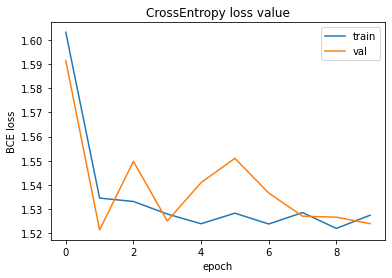

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

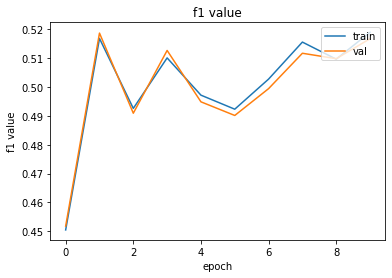

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

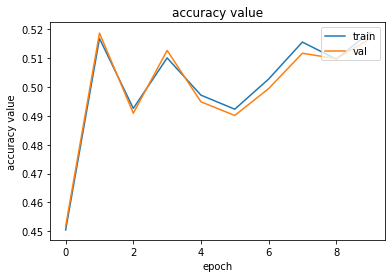

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5187, device='cuda:0')

### Эксперименты: без дропаута, kernel_size=2, 4

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[2, 4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:23,  3.00s/it]

Train loss: 1.691093385219574


16it [00:48,  3.03s/it]

Train loss: 1.644759751856327


24it [01:12,  3.00s/it]

Train loss: 1.6194132616122563


32it [01:36,  3.02s/it]

Train loss: 1.5966560542583466


40it [02:00,  2.98s/it]

Train loss: 1.5858111560344696


42it [02:04,  2.96s/it]



Evaluating on train...


8it [00:16,  2.08s/it]

Val loss: 1.5794222205877304, Val f1: 0.456787109375, Val accuracy: 0.456787109375


16it [00:34,  2.14s/it]

Val loss: 1.582660622894764, Val f1: 0.4527587890625, Val accuracy: 0.4527587890625


24it [00:51,  2.13s/it]

Val loss: 1.5819851358731587, Val f1: 0.4539388120174408, Val accuracy: 0.4539388120174408


32it [01:08,  2.10s/it]

Val loss: 1.5810585096478462, Val f1: 0.4560546875, Val accuracy: 0.4560546875


40it [01:25,  2.15s/it]

Val loss: 1.5806157797574998, Val f1: 0.45634767413139343, Val accuracy: 0.45634767413139343


42it [01:28,  2.10s/it]



Evaluating on test...


1it [00:02,  2.10s/it]

Val loss: 1.5908334255218506, Val f1: 0.44921875, Val accuracy: 0.44921875


2it [00:04,  2.14s/it]

Val loss: 1.5679818987846375, Val f1: 0.466796875, Val accuracy: 0.466796875


3it [00:06,  2.11s/it]

Val loss: 1.5820578336715698, Val f1: 0.4524739682674408, Val accuracy: 0.4524739682674408


4it [00:08,  2.13s/it]

Val loss: 1.583420068025589, Val f1: 0.44921875, Val accuracy: 0.44921875


5it [00:09,  1.97s/it]


Val loss: 1.5836206197738647, Val f1: 0.4484115540981293, Val accuracy: 0.4484115540981293

starting Epoch 1
Training...


8it [00:24,  2.98s/it]

Train loss: 1.543260857462883


16it [00:48,  3.03s/it]

Train loss: 1.536449670791626


24it [01:12,  3.04s/it]

Train loss: 1.5342283497254054


32it [01:36,  2.99s/it]

Train loss: 1.5322459675371647


40it [02:01,  3.00s/it]

Train loss: 1.5311139136552812


42it [02:05,  2.98s/it]



Evaluating on train...


8it [00:17,  2.14s/it]

Val loss: 1.53358955681324, Val f1: 0.509765625, Val accuracy: 0.509765625


16it [00:34,  2.19s/it]

Val loss: 1.5380373001098633, Val f1: 0.50537109375, Val accuracy: 0.50537109375


24it [00:52,  2.17s/it]

Val loss: 1.537502850095431, Val f1: 0.5048014521598816, Val accuracy: 0.5048014521598816


32it [01:09,  2.13s/it]

Val loss: 1.5362392887473106, Val f1: 0.50592041015625, Val accuracy: 0.50592041015625


40it [01:26,  2.17s/it]

Val loss: 1.5363917976617814, Val f1: 0.5054687857627869, Val accuracy: 0.5054687857627869


42it [01:29,  2.14s/it]



Evaluating on test...


1it [00:02,  2.14s/it]

Val loss: 1.5451574325561523, Val f1: 0.5, Val accuracy: 0.5


2it [00:04,  2.18s/it]

Val loss: 1.522991955280304, Val f1: 0.521484375, Val accuracy: 0.521484375


3it [00:06,  2.14s/it]

Val loss: 1.5361933310826619, Val f1: 0.5078125, Val accuracy: 0.5078125


4it [00:08,  2.15s/it]

Val loss: 1.5318972170352936, Val f1: 0.51025390625, Val accuracy: 0.51025390625


5it [00:09,  1.98s/it]


Val loss: 1.5346917629241943, Val f1: 0.5085353255271912, Val accuracy: 0.5085353255271912

starting Epoch 2
Training...


8it [00:23,  2.96s/it]

Train loss: 1.5302318036556244


16it [00:48,  3.08s/it]

Train loss: 1.534353293478489


24it [01:12,  3.02s/it]

Train loss: 1.52875750263532


32it [01:37,  2.98s/it]

Train loss: 1.5261568613350391


40it [02:01,  3.01s/it]

Train loss: 1.5255511790513991


42it [02:05,  2.98s/it]



Evaluating on train...


8it [00:16,  2.08s/it]

Val loss: 1.5924548506736755, Val f1: 0.448974609375, Val accuracy: 0.448974609375


16it [00:34,  2.17s/it]

Val loss: 1.5963247120380402, Val f1: 0.4444580078125, Val accuracy: 0.4444580078125


24it [00:51,  2.14s/it]

Val loss: 1.5973326514164607, Val f1: 0.443359375, Val accuracy: 0.443359375


32it [01:08,  2.11s/it]

Val loss: 1.5943292528390884, Val f1: 0.44757080078125, Val accuracy: 0.44757080078125


40it [01:25,  2.16s/it]

Val loss: 1.593119841814041, Val f1: 0.4488769471645355, Val accuracy: 0.4488769471645355


42it [01:28,  2.11s/it]



Evaluating on test...


1it [00:02,  2.20s/it]

Val loss: 1.6095771789550781, Val f1: 0.43359375, Val accuracy: 0.43359375


2it [00:04,  2.22s/it]

Val loss: 1.5924072861671448, Val f1: 0.44921875, Val accuracy: 0.44921875


3it [00:06,  2.17s/it]

Val loss: 1.600738247235616, Val f1: 0.4407552182674408, Val accuracy: 0.4407552182674408


4it [00:08,  2.18s/it]

Val loss: 1.5964772403240204, Val f1: 0.44482421875, Val accuracy: 0.44482421875


5it [00:10,  2.00s/it]


Val loss: 1.597284746170044, Val f1: 0.4422381520271301, Val accuracy: 0.44223809242248535

starting Epoch 3
Training...


8it [00:24,  2.99s/it]

Train loss: 1.5346832871437073


16it [00:48,  3.04s/it]

Train loss: 1.5278998091816902


24it [01:12,  3.01s/it]

Train loss: 1.5242433349291484


32it [01:36,  3.01s/it]

Train loss: 1.5246191769838333


40it [02:01,  3.02s/it]

Train loss: 1.5250317126512527


42it [02:05,  2.98s/it]



Evaluating on train...


8it [00:16,  2.07s/it]

Val loss: 1.5453015118837357, Val f1: 0.49365234375, Val accuracy: 0.49365234375


16it [00:34,  2.13s/it]

Val loss: 1.5488912165164948, Val f1: 0.490234375, Val accuracy: 0.490234375


24it [00:51,  2.13s/it]

Val loss: 1.5489667157332103, Val f1: 0.4894205927848816, Val accuracy: 0.4894205927848816


32it [01:07,  2.08s/it]

Val loss: 1.5472771488130093, Val f1: 0.49139404296875, Val accuracy: 0.49139404296875


40it [01:24,  2.12s/it]

Val loss: 1.5470020800828934, Val f1: 0.4925293028354645, Val accuracy: 0.4925293028354645


42it [01:27,  2.09s/it]



Evaluating on test...


1it [00:02,  2.07s/it]

Val loss: 1.5606019496917725, Val f1: 0.4765625, Val accuracy: 0.4765625


2it [00:04,  2.11s/it]

Val loss: 1.5345869064331055, Val f1: 0.50390625, Val accuracy: 0.50390625


3it [00:06,  2.09s/it]

Val loss: 1.5499053796132405, Val f1: 0.48828125, Val accuracy: 0.48828125


4it [00:08,  2.11s/it]

Val loss: 1.548706442117691, Val f1: 0.48681640625, Val accuracy: 0.48681640625


5it [00:09,  1.94s/it]


Val loss: 1.5491291284561157, Val f1: 0.4891209304332733, Val accuracy: 0.4891209304332733

starting Epoch 4
Training...


8it [00:23,  2.93s/it]

Train loss: 1.529705449938774


16it [00:47,  2.98s/it]

Train loss: 1.5243095010519028


24it [01:11,  2.96s/it]

Train loss: 1.5208937525749207


32it [01:35,  2.97s/it]

Train loss: 1.5222666375339031


40it [01:58,  2.96s/it]

Train loss: 1.5224332183599472


42it [02:02,  2.93s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.5242245346307755, Val f1: 0.513427734375, Val accuracy: 0.513427734375


16it [00:34,  2.17s/it]

Val loss: 1.5264015570282936, Val f1: 0.5101318359375, Val accuracy: 0.5101318359375


24it [00:51,  2.09s/it]

Val loss: 1.525601441661517, Val f1: 0.5104166865348816, Val accuracy: 0.5104166865348816


32it [01:07,  2.07s/it]

Val loss: 1.5248241610825062, Val f1: 0.512451171875, Val accuracy: 0.512451171875


40it [01:24,  2.12s/it]

Val loss: 1.5253265261650086, Val f1: 0.512011706829071, Val accuracy: 0.512011706829071


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.13s/it]

Val loss: 1.5294896364212036, Val f1: 0.513671875, Val accuracy: 0.513671875


2it [00:04,  2.14s/it]

Val loss: 1.5078032612800598, Val f1: 0.5341796875, Val accuracy: 0.5341796875


3it [00:06,  2.11s/it]

Val loss: 1.5261703332265217, Val f1: 0.5123698115348816, Val accuracy: 0.5123698115348816


4it [00:08,  2.12s/it]

Val loss: 1.5247781872749329, Val f1: 0.51220703125, Val accuracy: 0.51220703125


5it [00:09,  1.95s/it]


Val loss: 1.5263626337051392, Val f1: 0.510097861289978, Val accuracy: 0.510097861289978

starting Epoch 5
Training...


8it [00:23,  2.91s/it]

Train loss: 1.5256148427724838


16it [00:47,  3.00s/it]

Train loss: 1.5225099846720695


24it [01:11,  2.99s/it]

Train loss: 1.5297673990329106


32it [01:35,  2.97s/it]

Train loss: 1.5291066877543926


40it [01:59,  3.00s/it]

Train loss: 1.5287867069244385


42it [02:03,  2.94s/it]



Evaluating on train...


8it [00:16,  2.08s/it]

Val loss: 1.521923914551735, Val f1: 0.51806640625, Val accuracy: 0.51806640625


16it [00:34,  2.17s/it]

Val loss: 1.5227060914039612, Val f1: 0.5181884765625, Val accuracy: 0.5181884765625


24it [00:51,  2.12s/it]

Val loss: 1.5210455457369487, Val f1: 0.5204264521598816, Val accuracy: 0.5204264521598816


32it [01:07,  2.05s/it]

Val loss: 1.5212639570236206, Val f1: 0.52008056640625, Val accuracy: 0.52008056640625


40it [01:24,  2.09s/it]

Val loss: 1.5220463067293166, Val f1: 0.51904296875, Val accuracy: 0.51904296875


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.09s/it]

Val loss: 1.524421215057373, Val f1: 0.525390625, Val accuracy: 0.525390625


2it [00:04,  2.12s/it]

Val loss: 1.5025840997695923, Val f1: 0.5458984375, Val accuracy: 0.5458984375


3it [00:06,  2.07s/it]

Val loss: 1.5215239922205608, Val f1: 0.5240885615348816, Val accuracy: 0.5240885615348816


4it [00:08,  2.10s/it]

Val loss: 1.519762247800827, Val f1: 0.5234375, Val accuracy: 0.5234375


5it [00:09,  1.93s/it]


Val loss: 1.5218963623046875, Val f1: 0.519082248210907, Val accuracy: 0.519082248210907

starting Epoch 6
Training...


8it [00:23,  2.93s/it]

Train loss: 1.5230949223041534


16it [00:48,  3.03s/it]

Train loss: 1.5202202647924423


24it [01:12,  3.02s/it]

Train loss: 1.5249387472867966


32it [01:35,  2.93s/it]

Train loss: 1.5233358852565289


40it [01:59,  2.98s/it]

Train loss: 1.5232570588588714


42it [02:03,  2.95s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.5210232138633728, Val f1: 0.520751953125, Val accuracy: 0.520751953125


16it [00:33,  2.12s/it]

Val loss: 1.5212272182106972, Val f1: 0.521240234375, Val accuracy: 0.521240234375


24it [00:50,  2.12s/it]

Val loss: 1.519423320889473, Val f1: 0.5231119990348816, Val accuracy: 0.5231119990348816


32it [01:07,  2.08s/it]

Val loss: 1.5198399312794209, Val f1: 0.52239990234375, Val accuracy: 0.52239990234375


40it [01:24,  2.14s/it]

Val loss: 1.5208542943000793, Val f1: 0.521044909954071, Val accuracy: 0.521044909954071


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.12s/it]

Val loss: 1.5237780809402466, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:04,  2.15s/it]

Val loss: 1.5025299787521362, Val f1: 0.5419921875, Val accuracy: 0.5419921875


3it [00:06,  2.10s/it]

Val loss: 1.521845857302348, Val f1: 0.5208333730697632, Val accuracy: 0.5208333730697632


4it [00:08,  2.11s/it]

Val loss: 1.5202959775924683, Val f1: 0.52001953125, Val accuracy: 0.52001953125


5it [00:09,  1.94s/it]


Val loss: 1.522107720375061, Val f1: 0.5176767706871033, Val accuracy: 0.5176767706871033

starting Epoch 7
Training...


8it [00:23,  2.90s/it]

Train loss: 1.5239346325397491


16it [00:47,  2.98s/it]

Train loss: 1.5220208764076233


24it [01:11,  2.94s/it]

Train loss: 1.5186517387628555


32it [01:34,  2.92s/it]

Train loss: 1.5192017406225204


40it [01:58,  2.98s/it]

Train loss: 1.5199765861034393


42it [02:02,  2.91s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.519058272242546, Val f1: 0.521240234375, Val accuracy: 0.521240234375


16it [00:33,  2.13s/it]

Val loss: 1.5195809751749039, Val f1: 0.5213623046875, Val accuracy: 0.5213623046875


24it [00:50,  2.06s/it]

Val loss: 1.5177570631106694, Val f1: 0.522705078125, Val accuracy: 0.522705078125


32it [01:07,  2.09s/it]

Val loss: 1.5179519020020962, Val f1: 0.5225830078125, Val accuracy: 0.5225830078125


40it [01:24,  2.15s/it]

Val loss: 1.5187347382307053, Val f1: 0.521435558795929, Val accuracy: 0.521435558795929


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.13s/it]

Val loss: 1.5211708545684814, Val f1: 0.529296875, Val accuracy: 0.529296875


2it [00:04,  2.15s/it]

Val loss: 1.5003823637962341, Val f1: 0.546875, Val accuracy: 0.546875


3it [00:06,  2.12s/it]

Val loss: 1.5190478563308716, Val f1: 0.52734375, Val accuracy: 0.52734375


4it [00:08,  2.13s/it]

Val loss: 1.5179907083511353, Val f1: 0.52490234375, Val accuracy: 0.52490234375


5it [00:09,  1.96s/it]


Val loss: 1.5205489635467528, Val f1: 0.5202540755271912, Val accuracy: 0.5202540755271912

starting Epoch 8
Training...


8it [00:23,  2.92s/it]

Train loss: 1.520395427942276


16it [00:48,  3.01s/it]

Train loss: 1.515891745686531


24it [01:12,  2.99s/it]

Train loss: 1.5172763516505559


32it [01:36,  3.00s/it]

Train loss: 1.5187040641903877


40it [02:00,  2.99s/it]

Train loss: 1.5164580255746842


42it [02:04,  2.95s/it]



Evaluating on train...


8it [00:16,  2.03s/it]

Val loss: 1.5753276646137238, Val f1: 0.451904296875, Val accuracy: 0.451904296875


16it [00:33,  2.14s/it]

Val loss: 1.5776658952236176, Val f1: 0.4478759765625, Val accuracy: 0.4478759765625


24it [00:50,  2.11s/it]

Val loss: 1.5779785563548405, Val f1: 0.4458821713924408, Val accuracy: 0.4458821713924408


32it [01:07,  2.08s/it]

Val loss: 1.5764277204871178, Val f1: 0.44873046875, Val accuracy: 0.44873046875


40it [01:24,  2.13s/it]

Val loss: 1.5751751780509948, Val f1: 0.45068359375, Val accuracy: 0.45068359375


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:02,  2.08s/it]

Val loss: 1.578906536102295, Val f1: 0.435546875, Val accuracy: 0.435546875


2it [00:04,  2.13s/it]

Val loss: 1.5617635250091553, Val f1: 0.4521484375, Val accuracy: 0.4521484375


3it [00:06,  2.09s/it]

Val loss: 1.574365258216858, Val f1: 0.443359375, Val accuracy: 0.443359375


4it [00:08,  2.13s/it]

Val loss: 1.575839877128601, Val f1: 0.44287109375, Val accuracy: 0.44287109375


5it [00:09,  1.95s/it]


Val loss: 1.5754855871200562, Val f1: 0.4433334469795227, Val accuracy: 0.4433334469795227

starting Epoch 9
Training...


8it [00:23,  2.93s/it]

Train loss: 1.6469772309064865


16it [00:48,  3.01s/it]

Train loss: 1.5979926586151123


24it [01:12,  3.05s/it]

Train loss: 1.5827940454085667


32it [01:36,  2.94s/it]

Train loss: 1.5701412595808506


40it [02:00,  2.99s/it]

Train loss: 1.5631447792053224


42it [02:03,  2.95s/it]



Evaluating on train...


8it [00:16,  2.07s/it]

Val loss: 1.5271789729595184, Val f1: 0.52099609375, Val accuracy: 0.52099609375


16it [00:33,  2.11s/it]

Val loss: 1.528389148414135, Val f1: 0.519287109375, Val accuracy: 0.519287109375


24it [00:50,  2.09s/it]

Val loss: 1.5264866054058075, Val f1: 0.521728515625, Val accuracy: 0.521728515625


32it [01:07,  2.07s/it]

Val loss: 1.5269851982593536, Val f1: 0.520751953125, Val accuracy: 0.520751953125


40it [01:24,  2.12s/it]

Val loss: 1.52776697576046, Val f1: 0.5191406607627869, Val accuracy: 0.5191406607627869


42it [01:27,  2.07s/it]



Evaluating on test...


1it [00:02,  2.04s/it]

Val loss: 1.5267783403396606, Val f1: 0.53125, Val accuracy: 0.53125


2it [00:04,  2.06s/it]

Val loss: 1.5062680840492249, Val f1: 0.5537109375, Val accuracy: 0.5537109375


3it [00:06,  2.04s/it]

Val loss: 1.5246171553929646, Val f1: 0.5305989980697632, Val accuracy: 0.5305989980697632


4it [00:08,  2.07s/it]

Val loss: 1.5235908031463623, Val f1: 0.529296875, Val accuracy: 0.529296875


5it [00:09,  1.90s/it]

Val loss: 1.5254477739334107, Val f1: 0.5257630944252014, Val accuracy: 0.5257630944252014


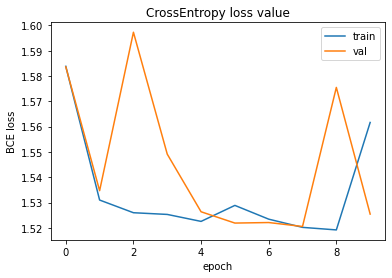

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

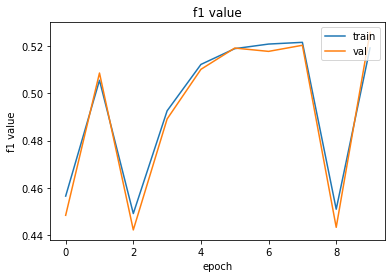

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

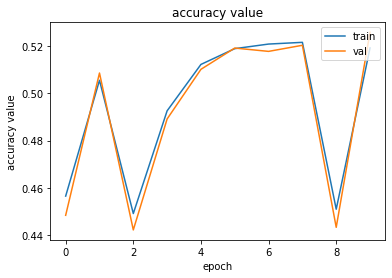

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5258, device='cuda:0')

### Эксперименты: без дропаута, kernel_size=3, 4

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[3, 4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)
8it [00:23,  2.96s/it]

Train loss: 1.702565386891365


16it [00:47,  2.97s/it]

Train loss: 1.6706772223114967


24it [01:11,  2.98s/it]

Train loss: 1.6506159206231434


32it [01:35,  2.97s/it]

Train loss: 1.6330911628901958


40it [01:58,  2.93s/it]

Train loss: 1.6162853568792344


42it [02:02,  2.92s/it]



Evaluating on train...


8it [00:16,  2.02s/it]

Val loss: 1.5555698573589325, Val f1: 0.490966796875, Val accuracy: 0.490966796875


16it [00:32,  2.06s/it]

Val loss: 1.5507645532488823, Val f1: 0.4970703125, Val accuracy: 0.4970703125


24it [00:49,  2.10s/it]

Val loss: 1.5500002255042393, Val f1: 0.4974772334098816, Val accuracy: 0.4974772334098816


32it [01:05,  2.07s/it]

Val loss: 1.5493849627673626, Val f1: 0.49847412109375, Val accuracy: 0.49847412109375


40it [01:21,  2.01s/it]

Val loss: 1.5464469909667968, Val f1: 0.502685546875, Val accuracy: 0.502685546875


42it [01:24,  2.01s/it]



Evaluating on test...


1it [00:01,  1.96s/it]

Val loss: 1.5399872064590454, Val f1: 0.51171875, Val accuracy: 0.51171875


2it [00:03,  1.99s/it]

Val loss: 1.5376341938972473, Val f1: 0.51171875, Val accuracy: 0.51171875


3it [00:05,  2.00s/it]

Val loss: 1.5408381223678589, Val f1: 0.5065104365348816, Val accuracy: 0.5065104365348816


4it [00:08,  2.03s/it]

Val loss: 1.5447295904159546, Val f1: 0.50048828125, Val accuracy: 0.50048828125


5it [00:09,  1.87s/it]


Val loss: 1.5460693120956421, Val f1: 0.49939393997192383, Val accuracy: 0.49939393997192383

starting Epoch 1
Training...


8it [00:23,  2.93s/it]

Train loss: 1.549798309803009


16it [00:47,  2.96s/it]

Train loss: 1.53658015280962


24it [01:10,  2.97s/it]

Train loss: 1.5365328937768936


32it [01:34,  2.95s/it]

Train loss: 1.5341179557144642


40it [01:57,  2.90s/it]

Train loss: 1.5430375188589096


42it [02:01,  2.89s/it]



Evaluating on train...


8it [00:16,  2.03s/it]

Val loss: 1.597955971956253, Val f1: 0.4560546875, Val accuracy: 0.4560546875


16it [00:33,  2.13s/it]

Val loss: 1.5973809659481049, Val f1: 0.457763671875, Val accuracy: 0.457763671875


24it [00:50,  2.10s/it]

Val loss: 1.595219021042188, Val f1: 0.46240234375, Val accuracy: 0.46240234375


32it [01:06,  2.09s/it]

Val loss: 1.5940338671207428, Val f1: 0.46270751953125, Val accuracy: 0.46270751953125


40it [01:23,  2.05s/it]

Val loss: 1.5920414686203004, Val f1: 0.46533203125, Val accuracy: 0.46533203125


42it [01:25,  2.04s/it]



Evaluating on test...


1it [00:02,  2.02s/it]

Val loss: 1.5858707427978516, Val f1: 0.470703125, Val accuracy: 0.470703125


2it [00:04,  2.01s/it]

Val loss: 1.578568935394287, Val f1: 0.4775390625, Val accuracy: 0.4775390625


3it [00:06,  2.00s/it]

Val loss: 1.5766663153966267, Val f1: 0.484375, Val accuracy: 0.484375


4it [00:08,  2.03s/it]

Val loss: 1.5818122029304504, Val f1: 0.4755859375, Val accuracy: 0.4755859375


5it [00:09,  1.88s/it]


Val loss: 1.5823172330856323, Val f1: 0.4728275239467621, Val accuracy: 0.4728275239467621

starting Epoch 2
Training...


8it [00:23,  2.93s/it]

Train loss: 1.5879576653242111


16it [00:47,  2.98s/it]

Train loss: 1.559716857969761


24it [01:11,  2.97s/it]

Train loss: 1.5523964216311772


32it [01:34,  2.98s/it]

Train loss: 1.5454954467713833


40it [01:58,  2.91s/it]

Train loss: 1.5379018574953078


42it [02:02,  2.91s/it]



Evaluating on train...


8it [00:16,  2.01s/it]

Val loss: 1.5411669164896011, Val f1: 0.505859375, Val accuracy: 0.505859375


16it [00:33,  2.07s/it]

Val loss: 1.5374274849891663, Val f1: 0.510986328125, Val accuracy: 0.510986328125


24it [00:49,  2.10s/it]

Val loss: 1.53639055788517, Val f1: 0.5118001699447632, Val accuracy: 0.5118001699447632


32it [01:06,  2.11s/it]

Val loss: 1.5352098047733307, Val f1: 0.51373291015625, Val accuracy: 0.51373291015625


40it [01:23,  2.10s/it]

Val loss: 1.5320733189582825, Val f1: 0.517529308795929, Val accuracy: 0.517529308795929


42it [01:25,  2.04s/it]



Evaluating on test...


1it [00:02,  2.01s/it]

Val loss: 1.5315375328063965, Val f1: 0.509765625, Val accuracy: 0.509765625


2it [00:04,  2.09s/it]

Val loss: 1.5277186632156372, Val f1: 0.515625, Val accuracy: 0.515625


3it [00:06,  2.09s/it]

Val loss: 1.5297936995824177, Val f1: 0.5123698115348816, Val accuracy: 0.5123698115348816


4it [00:08,  2.09s/it]

Val loss: 1.5310697853565216, Val f1: 0.5107421875, Val accuracy: 0.5107421875


5it [00:09,  1.93s/it]


Val loss: 1.5311965227127076, Val f1: 0.5102548599243164, Val accuracy: 0.5102548599243164

starting Epoch 3
Training...


8it [00:24,  2.97s/it]

Train loss: 1.5364007353782654


16it [00:48,  3.00s/it]

Train loss: 1.529392071068287


24it [01:11,  3.00s/it]

Train loss: 1.5303305834531784


32it [01:35,  2.96s/it]

Train loss: 1.5271268486976624


40it [01:58,  2.89s/it]

Train loss: 1.5240231454372406


42it [02:02,  2.91s/it]



Evaluating on train...


8it [00:16,  1.98s/it]

Val loss: 1.5372437089681625, Val f1: 0.50048828125, Val accuracy: 0.50048828125


16it [00:32,  2.03s/it]

Val loss: 1.531105600297451, Val f1: 0.50439453125, Val accuracy: 0.50439453125


24it [00:48,  2.04s/it]

Val loss: 1.5300182898839314, Val f1: 0.505615234375, Val accuracy: 0.505615234375


32it [01:04,  2.03s/it]

Val loss: 1.5293970964848995, Val f1: 0.506591796875, Val accuracy: 0.506591796875


40it [01:20,  1.98s/it]

Val loss: 1.5264094203710556, Val f1: 0.5103515982627869, Val accuracy: 0.5103515982627869


42it [01:23,  1.98s/it]



Evaluating on test...


1it [00:01,  1.93s/it]

Val loss: 1.5159893035888672, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:03,  1.98s/it]

Val loss: 1.5160533785820007, Val f1: 0.52734375, Val accuracy: 0.52734375


3it [00:05,  1.97s/it]

Val loss: 1.521129846572876, Val f1: 0.5208333730697632, Val accuracy: 0.5208333730697632


4it [00:07,  1.98s/it]

Val loss: 1.5273617804050446, Val f1: 0.51220703125, Val accuracy: 0.51220703125


5it [00:09,  1.84s/it]


Val loss: 1.5291301488876343, Val f1: 0.5094334483146667, Val accuracy: 0.5094334483146667

starting Epoch 4
Training...


8it [00:23,  2.90s/it]

Train loss: 1.5309037268161774


16it [00:47,  2.98s/it]

Train loss: 1.532461516559124


24it [01:10,  2.97s/it]

Train loss: 1.528596669435501


32it [01:34,  2.97s/it]

Train loss: 1.5272542797029018


40it [01:58,  2.96s/it]

Train loss: 1.5235237330198288


42it [02:01,  2.90s/it]



Evaluating on train...


8it [00:16,  2.08s/it]

Val loss: 1.5300037562847137, Val f1: 0.5068359375, Val accuracy: 0.5068359375


16it [00:33,  2.11s/it]

Val loss: 1.524743802845478, Val f1: 0.5142822265625, Val accuracy: 0.5142822265625


24it [00:50,  2.11s/it]

Val loss: 1.5240135043859482, Val f1: 0.5140787959098816, Val accuracy: 0.5140787959098816


32it [01:07,  2.08s/it]

Val loss: 1.5228905864059925, Val f1: 0.5146484375, Val accuracy: 0.5146484375


40it [01:23,  2.04s/it]

Val loss: 1.5198398649692535, Val f1: 0.5177246332168579, Val accuracy: 0.5177246332168579


42it [01:26,  2.05s/it]



Evaluating on test...


1it [00:02,  2.00s/it]

Val loss: 1.518742561340332, Val f1: 0.5234375, Val accuracy: 0.5234375


2it [00:04,  2.02s/it]

Val loss: 1.513893485069275, Val f1: 0.525390625, Val accuracy: 0.525390625


3it [00:06,  2.01s/it]

Val loss: 1.5174248615900676, Val f1: 0.5188802480697632, Val accuracy: 0.5188802480697632


4it [00:08,  2.05s/it]

Val loss: 1.519436091184616, Val f1: 0.517578125, Val accuracy: 0.517578125


5it [00:09,  1.89s/it]


Val loss: 1.5204859256744385, Val f1: 0.5163881182670593, Val accuracy: 0.5163881182670593

starting Epoch 5
Training...


8it [00:23,  2.95s/it]

Train loss: 1.5316770523786545


16it [00:48,  3.03s/it]

Train loss: 1.528843879699707


24it [01:12,  3.05s/it]

Train loss: 1.525574952363968


32it [01:36,  3.04s/it]

Train loss: 1.5273555554449558


40it [02:00,  3.01s/it]

Train loss: 1.5244524657726288


42it [02:04,  2.97s/it]



Evaluating on train...


8it [00:17,  2.13s/it]

Val loss: 1.5463734567165375, Val f1: 0.503173828125, Val accuracy: 0.503173828125


16it [00:34,  2.16s/it]

Val loss: 1.543566957116127, Val f1: 0.50634765625, Val accuracy: 0.50634765625


24it [00:51,  2.16s/it]

Val loss: 1.5420129398504894, Val f1: 0.5069987177848816, Val accuracy: 0.5069987177848816


32it [01:08,  2.09s/it]

Val loss: 1.5405865125358105, Val f1: 0.50885009765625, Val accuracy: 0.50885009765625


40it [01:24,  2.03s/it]

Val loss: 1.5375858277082444, Val f1: 0.5123535394668579, Val accuracy: 0.5123535394668579


42it [01:27,  2.08s/it]



Evaluating on test...


1it [00:01,  1.95s/it]

Val loss: 1.5397405624389648, Val f1: 0.505859375, Val accuracy: 0.505859375


2it [00:04,  2.03s/it]

Val loss: 1.5316476225852966, Val f1: 0.5166015625, Val accuracy: 0.5166015625


3it [00:06,  2.04s/it]

Val loss: 1.5329435269037883, Val f1: 0.5104166865348816, Val accuracy: 0.5104166865348816


4it [00:08,  2.06s/it]

Val loss: 1.5350053012371063, Val f1: 0.509765625, Val accuracy: 0.509765625


5it [00:09,  1.90s/it]


Val loss: 1.5356536388397217, Val f1: 0.5101380944252014, Val accuracy: 0.5101380944252014

starting Epoch 6
Training...


8it [00:23,  2.95s/it]

Train loss: 1.5345287322998047


16it [00:47,  3.02s/it]

Train loss: 1.5262774899601936


24it [01:11,  3.00s/it]

Train loss: 1.5233417054017384


32it [01:35,  2.98s/it]

Train loss: 1.5219684913754463


40it [01:58,  2.94s/it]

Train loss: 1.5191107451915742


42it [02:02,  2.92s/it]



Evaluating on train...


8it [00:16,  2.02s/it]

Val loss: 1.5406151860952377, Val f1: 0.495849609375, Val accuracy: 0.495849609375


16it [00:33,  2.09s/it]

Val loss: 1.5335139706730843, Val f1: 0.5037841796875, Val accuracy: 0.5037841796875


24it [00:49,  2.09s/it]

Val loss: 1.532069593667984, Val f1: 0.5037435293197632, Val accuracy: 0.5037435293197632


32it [01:05,  2.07s/it]

Val loss: 1.5296408347785473, Val f1: 0.50537109375, Val accuracy: 0.50537109375


40it [01:22,  1.99s/it]

Val loss: 1.5264689177274704, Val f1: 0.5086426138877869, Val accuracy: 0.5086426138877869


42it [01:24,  2.02s/it]



Evaluating on test...


1it [00:01,  1.95s/it]

Val loss: 1.5252617597579956, Val f1: 0.515625, Val accuracy: 0.515625


2it [00:03,  1.98s/it]

Val loss: 1.5235121846199036, Val f1: 0.5166015625, Val accuracy: 0.5166015625


3it [00:06,  2.02s/it]

Val loss: 1.5283486445744832, Val f1: 0.5091146230697632, Val accuracy: 0.5091146230697632


4it [00:08,  2.04s/it]

Val loss: 1.5324116051197052, Val f1: 0.5048828125, Val accuracy: 0.5048828125


5it [00:09,  1.88s/it]


Val loss: 1.532637071609497, Val f1: 0.5022451281547546, Val accuracy: 0.5022451281547546

starting Epoch 7
Training...


8it [00:23,  2.92s/it]

Train loss: 1.529915064573288


16it [00:47,  3.00s/it]

Train loss: 1.5245543494820595


24it [01:11,  3.00s/it]

Train loss: 1.5220649043718975


32it [01:35,  2.98s/it]

Train loss: 1.5213781632483006


40it [01:58,  2.93s/it]

Train loss: 1.5183256983757019


42it [02:02,  2.91s/it]



Evaluating on train...


8it [00:16,  2.04s/it]

Val loss: 1.5347542315721512, Val f1: 0.502685546875, Val accuracy: 0.502685546875


16it [00:33,  2.10s/it]

Val loss: 1.5285000279545784, Val f1: 0.51025390625, Val accuracy: 0.51025390625


24it [00:49,  2.10s/it]

Val loss: 1.527614156405131, Val f1: 0.5100911855697632, Val accuracy: 0.5100911855697632


32it [01:06,  2.08s/it]

Val loss: 1.5261111482977867, Val f1: 0.51055908203125, Val accuracy: 0.51055908203125


40it [01:22,  2.04s/it]

Val loss: 1.522987723350525, Val f1: 0.513720691204071, Val accuracy: 0.513720691204071


42it [01:25,  2.03s/it]



Evaluating on test...


1it [00:01,  1.96s/it]

Val loss: 1.520819067955017, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.01s/it]

Val loss: 1.5196327567100525, Val f1: 0.515625, Val accuracy: 0.515625


3it [00:06,  2.01s/it]

Val loss: 1.5239471594492595, Val f1: 0.5091146230697632, Val accuracy: 0.5091146230697632


4it [00:08,  2.02s/it]

Val loss: 1.526112586259842, Val f1: 0.50830078125, Val accuracy: 0.50830078125


5it [00:09,  1.87s/it]


Val loss: 1.527735161781311, Val f1: 0.5056439638137817, Val accuracy: 0.5056439638137817

starting Epoch 8
Training...


8it [00:23,  2.90s/it]

Train loss: 1.5310269445180893


16it [00:47,  2.97s/it]

Train loss: 1.5248331502079964


24it [01:10,  2.97s/it]

Train loss: 1.5251746128002803


32it [01:34,  2.96s/it]

Train loss: 1.5220090486109257


40it [01:57,  2.91s/it]

Train loss: 1.5234811395406722


42it [02:01,  2.89s/it]



Evaluating on train...


8it [00:16,  2.05s/it]

Val loss: 1.6374009549617767, Val f1: 0.3837890625, Val accuracy: 0.3837890625


16it [00:33,  2.09s/it]

Val loss: 1.6257296577095985, Val f1: 0.3961181640625, Val accuracy: 0.3961181640625


24it [00:49,  2.10s/it]

Val loss: 1.6247582336266835, Val f1: 0.397216796875, Val accuracy: 0.397216796875


32it [01:06,  2.05s/it]

Val loss: 1.6251097172498703, Val f1: 0.39569091796875, Val accuracy: 0.39569091796875


40it [01:22,  2.02s/it]

Val loss: 1.6229477912187575, Val f1: 0.3976074159145355, Val accuracy: 0.3976074159145355


42it [01:25,  2.03s/it]



Evaluating on test...


1it [00:01,  1.95s/it]

Val loss: 1.633607268333435, Val f1: 0.38671875, Val accuracy: 0.38671875


2it [00:03,  1.98s/it]

Val loss: 1.6301965117454529, Val f1: 0.3916015625, Val accuracy: 0.3916015625


3it [00:05,  1.99s/it]

Val loss: 1.625157356262207, Val f1: 0.3990885615348816, Val accuracy: 0.3990885615348816


4it [00:07,  2.00s/it]

Val loss: 1.6278131604194641, Val f1: 0.39453125, Val accuracy: 0.39453125


5it [00:09,  1.86s/it]


Val loss: 1.625797939300537, Val f1: 0.3946947753429413, Val accuracy: 0.3946947753429413

starting Epoch 9
Training...


8it [00:23,  2.91s/it]

Train loss: 1.56845523416996


16it [00:47,  2.98s/it]

Train loss: 1.5473022013902664


24it [01:10,  2.95s/it]

Train loss: 1.5372573733329773


32it [01:34,  2.92s/it]

Train loss: 1.5327467247843742


40it [01:57,  2.92s/it]

Train loss: 1.5279636144638062


42it [02:01,  2.89s/it]



Evaluating on train...


8it [00:16,  2.04s/it]

Val loss: 1.5426911264657974, Val f1: 0.509521484375, Val accuracy: 0.509521484375


16it [00:33,  2.07s/it]

Val loss: 1.5380068570375443, Val f1: 0.5152587890625, Val accuracy: 0.5152587890625


24it [00:49,  2.08s/it]

Val loss: 1.537315621972084, Val f1: 0.514892578125, Val accuracy: 0.514892578125


32it [01:05,  2.05s/it]

Val loss: 1.536249503493309, Val f1: 0.51629638671875, Val accuracy: 0.51629638671875


40it [01:22,  2.07s/it]

Val loss: 1.532600736618042, Val f1: 0.519775390625, Val accuracy: 0.519775390625


42it [01:24,  2.02s/it]



Evaluating on test...


1it [00:01,  1.94s/it]

Val loss: 1.5331854820251465, Val f1: 0.513671875, Val accuracy: 0.513671875


2it [00:03,  2.00s/it]

Val loss: 1.530593991279602, Val f1: 0.51953125, Val accuracy: 0.51953125


3it [00:06,  2.01s/it]

Val loss: 1.531734546025594, Val f1: 0.5149739980697632, Val accuracy: 0.5149739980697632


4it [00:08,  2.03s/it]

Val loss: 1.5330549776554108, Val f1: 0.5166015625, Val accuracy: 0.5166015625


5it [00:09,  1.87s/it]

Val loss: 1.5324307918548583, Val f1: 0.5169357657432556, Val accuracy: 0.5169357657432556


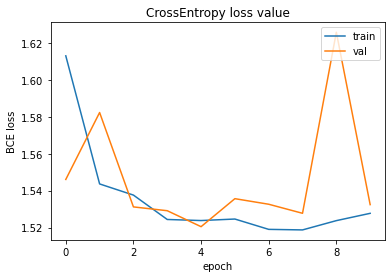

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

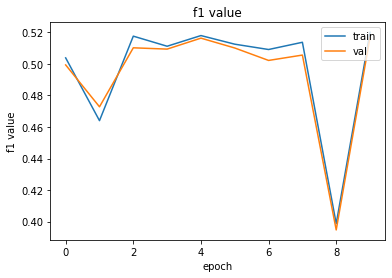

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

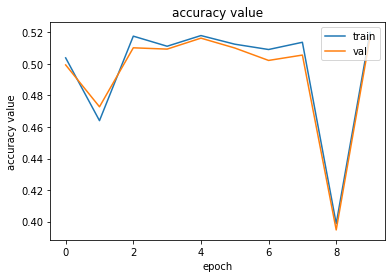

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5169, device='cuda:0')

### Эксперименты: без дропаута, kernel_size=[2, 3, 4]

In [ ]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[2, 3, 4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='no dropout', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:28,  3.49s/it]

Train loss: 1.7024618834257126


16it [00:56,  3.56s/it]

Train loss: 1.6264473050832748


24it [01:24,  3.54s/it]

Train loss: 1.599103068312009


32it [01:52,  3.51s/it]

Train loss: 1.5845414623618126


40it [02:20,  3.46s/it]

Train loss: 1.5710150718688964


42it [02:25,  3.46s/it]



Evaluating on train...


8it [00:18,  2.25s/it]

Val loss: 1.6083595156669617, Val f1: 0.41552734375, Val accuracy: 0.41552734375


16it [00:36,  2.31s/it]

Val loss: 1.5983669385313988, Val f1: 0.42626953125, Val accuracy: 0.42626953125


24it [00:54,  2.31s/it]

Val loss: 1.5976734310388565, Val f1: 0.4269205927848816, Val accuracy: 0.4269205927848816


32it [01:13,  2.30s/it]

Val loss: 1.5979570262134075, Val f1: 0.42645263671875, Val accuracy: 0.42645263671875


40it [01:31,  2.27s/it]

Val loss: 1.5951259106397628, Val f1: 0.4287109375, Val accuracy: 0.4287109375


42it [01:34,  2.25s/it]



Evaluating on test...


1it [00:02,  2.26s/it]

Val loss: 1.6013453006744385, Val f1: 0.4140625, Val accuracy: 0.4140625


2it [00:04,  2.29s/it]

Val loss: 1.5985846519470215, Val f1: 0.41796875, Val accuracy: 0.41796875


3it [00:06,  2.27s/it]

Val loss: 1.594526767730713, Val f1: 0.42578125, Val accuracy: 0.42578125


4it [00:09,  2.28s/it]

Val loss: 1.5955881178379059, Val f1: 0.42822265625, Val accuracy: 0.42822265625


5it [00:10,  2.11s/it]


Val loss: 1.5940802812576294, Val f1: 0.4316146969795227, Val accuracy: 0.4316146969795227

starting Epoch 1
Training...


8it [00:28,  3.52s/it]

Train loss: 1.5604272782802582


16it [00:56,  3.52s/it]

Train loss: 1.5464075058698654


24it [01:24,  3.52s/it]

Train loss: 1.5399410426616669


32it [01:52,  3.49s/it]

Train loss: 1.5364180281758308


40it [02:19,  3.45s/it]

Train loss: 1.530601054430008


42it [02:24,  3.44s/it]



Evaluating on train...


8it [00:18,  2.25s/it]

Val loss: 1.5492714792490005, Val f1: 0.491943359375, Val accuracy: 0.491943359375


16it [00:36,  2.29s/it]

Val loss: 1.5424598827958107, Val f1: 0.501220703125, Val accuracy: 0.501220703125


24it [00:54,  2.31s/it]

Val loss: 1.541823923587799, Val f1: 0.50146484375, Val accuracy: 0.50146484375


32it [01:12,  2.27s/it]

Val loss: 1.5414969213306904, Val f1: 0.50152587890625, Val accuracy: 0.50152587890625


40it [01:30,  2.23s/it]

Val loss: 1.5383855134248734, Val f1: 0.5047851800918579, Val accuracy: 0.5047851800918579


42it [01:33,  2.23s/it]



Evaluating on test...


1it [00:02,  2.14s/it]

Val loss: 1.5287585258483887, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.18s/it]

Val loss: 1.5299741625785828, Val f1: 0.515625, Val accuracy: 0.515625


3it [00:06,  2.20s/it]

Val loss: 1.5342239538828533, Val f1: 0.5091146230697632, Val accuracy: 0.5091146230697632


4it [00:08,  2.23s/it]

Val loss: 1.5372381806373596, Val f1: 0.5068359375, Val accuracy: 0.5068359375


5it [00:10,  2.06s/it]


Val loss: 1.5384138107299805, Val f1: 0.5038076639175415, Val accuracy: 0.5038076639175415

starting Epoch 2
Training...


8it [00:27,  3.46s/it]

Train loss: 1.535597875714302


16it [00:56,  3.51s/it]

Train loss: 1.5314485728740692


24it [01:23,  3.50s/it]

Train loss: 1.5276072372992833


32it [01:51,  3.48s/it]

Train loss: 1.529114130884409


40it [02:19,  3.43s/it]

Train loss: 1.528127208352089


42it [02:23,  3.42s/it]



Evaluating on train...


8it [00:18,  2.23s/it]

Val loss: 1.5394614785909653, Val f1: 0.4990234375, Val accuracy: 0.4990234375


16it [00:36,  2.29s/it]

Val loss: 1.5340979918837547, Val f1: 0.5072021484375, Val accuracy: 0.5072021484375


24it [00:54,  2.28s/it]

Val loss: 1.533544734120369, Val f1: 0.5079752802848816, Val accuracy: 0.5079752802848816


32it [01:12,  2.29s/it]

Val loss: 1.5329585671424866, Val f1: 0.5086669921875, Val accuracy: 0.5086669921875


40it [01:30,  2.23s/it]

Val loss: 1.5296278148889542, Val f1: 0.511962890625, Val accuracy: 0.511962890625


42it [01:33,  2.23s/it]



Evaluating on test...


1it [00:02,  2.17s/it]

Val loss: 1.5264188051223755, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.21s/it]

Val loss: 1.5243163704872131, Val f1: 0.51953125, Val accuracy: 0.51953125


3it [00:06,  2.21s/it]

Val loss: 1.5273278951644897, Val f1: 0.513671875, Val accuracy: 0.513671875


4it [00:08,  2.25s/it]

Val loss: 1.5281457304954529, Val f1: 0.515625, Val accuracy: 0.515625


5it [00:10,  2.08s/it]


Val loss: 1.5285421133041381, Val f1: 0.5128322243690491, Val accuracy: 0.5128322243690491

starting Epoch 3
Training...


8it [00:28,  3.48s/it]

Train loss: 1.5339922904968262


16it [00:56,  3.54s/it]

Train loss: 1.527920700609684


24it [01:24,  3.53s/it]

Train loss: 1.5256841977437336


32it [01:52,  3.50s/it]

Train loss: 1.5242499150335789


40it [02:19,  3.43s/it]

Train loss: 1.5208967953920365


42it [02:24,  3.43s/it]



Evaluating on train...


8it [00:18,  2.26s/it]

Val loss: 1.5492447912693024, Val f1: 0.4951171875, Val accuracy: 0.4951171875


16it [00:36,  2.29s/it]

Val loss: 1.5420937612652779, Val f1: 0.5023193359375, Val accuracy: 0.5023193359375


24it [00:54,  2.30s/it]

Val loss: 1.5415938297907512, Val f1: 0.502197265625, Val accuracy: 0.502197265625


32it [01:12,  2.28s/it]

Val loss: 1.5412335880100727, Val f1: 0.50250244140625, Val accuracy: 0.50250244140625


40it [01:30,  2.23s/it]

Val loss: 1.5380469501018523, Val f1: 0.506054699420929, Val accuracy: 0.506054699420929


42it [01:33,  2.24s/it]



Evaluating on test...


1it [00:02,  2.15s/it]

Val loss: 1.5306804180145264, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.23s/it]

Val loss: 1.5312196016311646, Val f1: 0.5166015625, Val accuracy: 0.5166015625


3it [00:06,  2.22s/it]

Val loss: 1.5341686805089314, Val f1: 0.51171875, Val accuracy: 0.51171875


4it [00:08,  2.23s/it]

Val loss: 1.5368872582912445, Val f1: 0.51025390625, Val accuracy: 0.51025390625


5it [00:10,  2.07s/it]


Val loss: 1.5378022909164428, Val f1: 0.5065420269966125, Val accuracy: 0.5065420269966125

starting Epoch 4
Training...


8it [00:27,  3.46s/it]

Train loss: 1.5407647639513016


16it [00:55,  3.51s/it]

Train loss: 1.5329005867242813


24it [01:23,  3.49s/it]

Train loss: 1.5279090106487274


32it [01:51,  3.49s/it]

Train loss: 1.525098528712988


40it [02:19,  3.43s/it]

Train loss: 1.5210260093212127


42it [02:23,  3.42s/it]



Evaluating on train...


8it [00:17,  2.22s/it]

Val loss: 1.5414226204156876, Val f1: 0.503662109375, Val accuracy: 0.503662109375


16it [00:36,  2.34s/it]

Val loss: 1.5397019237279892, Val f1: 0.5047607421875, Val accuracy: 0.5047607421875


24it [00:55,  2.33s/it]

Val loss: 1.5385118424892426, Val f1: 0.505615234375, Val accuracy: 0.505615234375


32it [01:13,  2.32s/it]

Val loss: 1.536797370761633, Val f1: 0.50799560546875, Val accuracy: 0.50799560546875


40it [01:32,  2.29s/it]

Val loss: 1.5334914833307267, Val f1: 0.5113769769668579, Val accuracy: 0.5113769769668579


42it [01:35,  2.26s/it]



Evaluating on test...


1it [00:02,  2.21s/it]

Val loss: 1.5388972759246826, Val f1: 0.50390625, Val accuracy: 0.50390625


2it [00:04,  2.26s/it]

Val loss: 1.5310816764831543, Val f1: 0.509765625, Val accuracy: 0.509765625


3it [00:06,  2.27s/it]

Val loss: 1.5325517654418945, Val f1: 0.505859375, Val accuracy: 0.505859375


4it [00:09,  2.27s/it]

Val loss: 1.5338752567768097, Val f1: 0.50830078125, Val accuracy: 0.50830078125


5it [00:10,  2.10s/it]


Val loss: 1.5333948612213135, Val f1: 0.5102950930595398, Val accuracy: 0.5102950930595398

starting Epoch 5
Training...


8it [00:28,  3.53s/it]

Train loss: 1.5557005107402802


16it [00:57,  3.64s/it]

Train loss: 1.5378070324659348


24it [01:26,  3.64s/it]

Train loss: 1.5311554620663326


32it [01:54,  3.57s/it]

Train loss: 1.5295834876596928


40it [02:23,  3.49s/it]

Train loss: 1.5243846386671067


42it [02:27,  3.51s/it]



Evaluating on train...


8it [00:18,  2.28s/it]

Val loss: 1.5361853390932083, Val f1: 0.508544921875, Val accuracy: 0.508544921875


16it [00:37,  2.36s/it]

Val loss: 1.5298870578408241, Val f1: 0.515869140625, Val accuracy: 0.515869140625


24it [00:55,  2.35s/it]

Val loss: 1.529289647936821, Val f1: 0.5157877802848816, Val accuracy: 0.5157877802848816


32it [01:14,  2.34s/it]

Val loss: 1.5283222384750843, Val f1: 0.51708984375, Val accuracy: 0.51708984375


40it [01:32,  2.28s/it]

Val loss: 1.5253103226423264, Val f1: 0.519970715045929, Val accuracy: 0.519970715045929


42it [01:35,  2.28s/it]



Evaluating on test...


1it [00:02,  2.19s/it]

Val loss: 1.5197738409042358, Val f1: 0.5234375, Val accuracy: 0.5234375


2it [00:04,  2.22s/it]

Val loss: 1.5195828080177307, Val f1: 0.5224609375, Val accuracy: 0.5224609375


3it [00:06,  2.24s/it]

Val loss: 1.5223394234975178, Val f1: 0.517578125, Val accuracy: 0.517578125


4it [00:09,  2.27s/it]

Val loss: 1.5239876210689545, Val f1: 0.5166015625, Val accuracy: 0.5166015625


5it [00:10,  2.09s/it]


Val loss: 1.5245315074920653, Val f1: 0.5149423480033875, Val accuracy: 0.5149423480033875

starting Epoch 6
Training...


8it [00:28,  3.54s/it]

Train loss: 1.5301290303468704


16it [00:57,  3.59s/it]

Train loss: 1.5225229635834694


24it [01:25,  3.60s/it]

Train loss: 1.529420167207718


32it [01:54,  3.58s/it]

Train loss: 1.5283990874886513


40it [02:22,  3.51s/it]

Train loss: 1.5239615112543106


42it [02:27,  3.50s/it]



Evaluating on train...


8it [00:18,  2.29s/it]

Val loss: 1.528710812330246, Val f1: 0.50927734375, Val accuracy: 0.50927734375


16it [00:37,  2.37s/it]

Val loss: 1.522945523262024, Val f1: 0.5155029296875, Val accuracy: 0.5155029296875


24it [00:56,  2.42s/it]

Val loss: 1.5224258601665497, Val f1: 0.5159505605697632, Val accuracy: 0.5159505605697632


32it [01:15,  2.40s/it]

Val loss: 1.5211335979402065, Val f1: 0.51715087890625, Val accuracy: 0.51715087890625


40it [01:34,  2.35s/it]

Val loss: 1.5179579198360442, Val f1: 0.520214855670929, Val accuracy: 0.520214855670929


42it [01:37,  2.32s/it]



Evaluating on test...


1it [00:02,  2.27s/it]

Val loss: 1.5180529356002808, Val f1: 0.517578125, Val accuracy: 0.517578125


2it [00:04,  2.31s/it]

Val loss: 1.513774573802948, Val f1: 0.5224609375, Val accuracy: 0.5224609375


3it [00:06,  2.32s/it]

Val loss: 1.5188018878300984, Val f1: 0.5169271230697632, Val accuracy: 0.5169271230697632


4it [00:09,  2.35s/it]

Val loss: 1.5199622511863708, Val f1: 0.51806640625, Val accuracy: 0.51806640625


5it [00:10,  2.17s/it]


Val loss: 1.5215102434158325, Val f1: 0.5161142349243164, Val accuracy: 0.5161142349243164

starting Epoch 7
Training...


8it [00:28,  3.58s/it]

Train loss: 1.5254634469747543


16it [00:57,  3.62s/it]

Train loss: 1.5213797688484192


24it [01:26,  3.62s/it]

Train loss: 1.5294420917828877


32it [01:55,  3.64s/it]

Train loss: 1.534314852207899


40it [02:23,  3.56s/it]

Train loss: 1.5301850140094757


42it [02:28,  3.54s/it]



Evaluating on train...


8it [00:19,  2.35s/it]

Val loss: 1.5565397143363953, Val f1: 0.47119140625, Val accuracy: 0.47119140625


16it [00:38,  2.40s/it]

Val loss: 1.5508706271648407, Val f1: 0.4771728515625, Val accuracy: 0.4771728515625


24it [00:57,  2.40s/it]

Val loss: 1.5501136581103008, Val f1: 0.477294921875, Val accuracy: 0.477294921875


32it [01:16,  2.39s/it]

Val loss: 1.5498231537640095, Val f1: 0.47747802734375, Val accuracy: 0.47747802734375


40it [01:34,  2.32s/it]

Val loss: 1.5466250687837602, Val f1: 0.4803222715854645, Val accuracy: 0.4803222715854645


42it [01:38,  2.33s/it]



Evaluating on test...


1it [00:02,  2.24s/it]

Val loss: 1.5384516716003418, Val f1: 0.4921875, Val accuracy: 0.4921875


2it [00:04,  2.28s/it]

Val loss: 1.5441272258758545, Val f1: 0.482421875, Val accuracy: 0.482421875


3it [00:06,  2.29s/it]

Val loss: 1.5449861288070679, Val f1: 0.48046875, Val accuracy: 0.48046875


4it [00:09,  2.33s/it]

Val loss: 1.545957326889038, Val f1: 0.48095703125, Val accuracy: 0.48095703125


5it [00:10,  2.15s/it]


Val loss: 1.5457767248153687, Val f1: 0.4804466664791107, Val accuracy: 0.4804466664791107

starting Epoch 8
Training...


8it [00:28,  3.57s/it]

Train loss: 1.5396464318037033


16it [00:57,  3.62s/it]

Train loss: 1.5311610773205757


24it [01:26,  3.61s/it]

Train loss: 1.5274123748143513


32it [01:54,  3.57s/it]

Train loss: 1.522197924554348


40it [02:22,  3.52s/it]

Train loss: 1.5215968489646912


42it [02:27,  3.51s/it]



Evaluating on train...


8it [00:18,  2.25s/it]

Val loss: 1.5873664915561676, Val f1: 0.4560546875, Val accuracy: 0.4560546875


16it [00:36,  2.33s/it]

Val loss: 1.5781764313578606, Val f1: 0.4658203125, Val accuracy: 0.4658203125


24it [00:55,  2.31s/it]

Val loss: 1.576651265223821, Val f1: 0.4676106870174408, Val accuracy: 0.4676106870174408


32it [01:13,  2.32s/it]

Val loss: 1.576240036636591, Val f1: 0.46795654296875, Val accuracy: 0.46795654296875


40it [01:31,  2.28s/it]

Val loss: 1.5724761813879014, Val f1: 0.4715332090854645, Val accuracy: 0.4715332090854645


42it [01:34,  2.26s/it]



Evaluating on test...


1it [00:02,  2.19s/it]

Val loss: 1.5698577165603638, Val f1: 0.48046875, Val accuracy: 0.48046875


2it [00:04,  2.24s/it]

Val loss: 1.5722739100456238, Val f1: 0.4765625, Val accuracy: 0.4765625


3it [00:06,  2.24s/it]

Val loss: 1.5681999524434407, Val f1: 0.4837239682674408, Val accuracy: 0.4837239682674408


4it [00:09,  2.26s/it]

Val loss: 1.5709015727043152, Val f1: 0.4765625, Val accuracy: 0.4765625


5it [00:10,  2.10s/it]


Val loss: 1.569119381904602, Val f1: 0.47825995087623596, Val accuracy: 0.47825995087623596

starting Epoch 9
Training...


8it [00:28,  3.51s/it]

Train loss: 1.5495466440916061


16it [00:56,  3.56s/it]

Train loss: 1.5311373099684715


24it [01:25,  3.60s/it]

Train loss: 1.5490067601203918


32it [01:53,  3.55s/it]

Train loss: 1.5553696043789387


40it [02:21,  3.50s/it]

Train loss: 1.5514469981193542


42it [02:26,  3.49s/it]



Evaluating on train...


8it [00:18,  2.28s/it]

Val loss: 1.554170310497284, Val f1: 0.50048828125, Val accuracy: 0.50048828125


16it [00:36,  2.30s/it]

Val loss: 1.5471767261624336, Val f1: 0.5057373046875, Val accuracy: 0.5057373046875


24it [00:55,  2.33s/it]

Val loss: 1.546322335799535, Val f1: 0.5069173574447632, Val accuracy: 0.5069173574447632


32it [01:13,  2.32s/it]

Val loss: 1.5450714156031609, Val f1: 0.508544921875, Val accuracy: 0.508544921875


40it [01:31,  2.26s/it]

Val loss: 1.541897815465927, Val f1: 0.5125976800918579, Val accuracy: 0.5125976800918579


42it [01:34,  2.26s/it]



Evaluating on test...


1it [00:02,  2.15s/it]

Val loss: 1.5427683591842651, Val f1: 0.515625, Val accuracy: 0.515625


2it [00:04,  2.20s/it]

Val loss: 1.5394644141197205, Val f1: 0.521484375, Val accuracy: 0.521484375


3it [00:06,  2.21s/it]

Val loss: 1.541025161743164, Val f1: 0.5169271230697632, Val accuracy: 0.5169271230697632


4it [00:08,  2.24s/it]

Val loss: 1.5426002740859985, Val f1: 0.51416015625, Val accuracy: 0.51416015625


5it [00:10,  2.07s/it]

Val loss: 1.5432809114456176, Val f1: 0.5116603374481201, Val accuracy: 0.5116603374481201


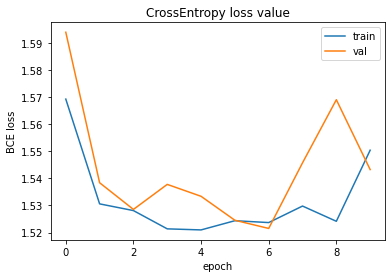

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

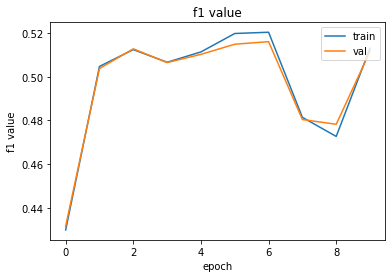

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

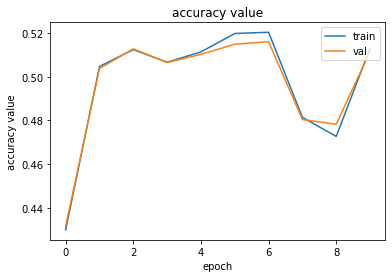

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max(accuracy_eval)

tensor(0.5161, device='cuda:0')

### Эксперименты: дропаут before CNN, kernel_size=4

Если рассматривать эксперименты только с размером фильтров, то в целом результаты получились сравнимо одинаковыми везде, кроме фильтра размера 4. Это расходится с опытом авторов статьи, у которых наибольший вклад вносил фильтр размера 3. Дальнейшие эксперименты с дропаутами проведем на фильтре 4.

In [24]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='before CNN', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [25]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)
8it [00:20,  2.54s/it]

Train loss: 1.699747458100319


16it [00:41,  2.68s/it]

Train loss: 1.6529192179441452


24it [01:01,  2.56s/it]

Train loss: 1.6265032986799877


32it [01:22,  2.59s/it]

Train loss: 1.6100093871355057


40it [01:42,  2.54s/it]

Train loss: 1.594407430291176


42it [01:46,  2.53s/it]



Evaluating on train...


8it [00:15,  1.95s/it]

Val loss: 1.561522975564003, Val f1: 0.46630859375, Val accuracy: 0.46630859375


16it [00:31,  1.90s/it]

Val loss: 1.5580101013183594, Val f1: 0.468505859375, Val accuracy: 0.468505859375


24it [00:46,  1.92s/it]

Val loss: 1.5571947743495305, Val f1: 0.4698079526424408, Val accuracy: 0.4698079526424408


32it [01:02,  2.01s/it]

Val loss: 1.5615788958966732, Val f1: 0.46514892578125, Val accuracy: 0.46514892578125


40it [01:18,  2.01s/it]

Val loss: 1.560454460978508, Val f1: 0.467529296875, Val accuracy: 0.467529296875


42it [01:21,  1.93s/it]



Evaluating on test...


1it [00:01,  1.89s/it]

Val loss: 1.5351617336273193, Val f1: 0.494140625, Val accuracy: 0.494140625


2it [00:04,  2.03s/it]

Val loss: 1.5536593198776245, Val f1: 0.4736328125, Val accuracy: 0.4736328125


3it [00:05,  1.98s/it]

Val loss: 1.5615368684132893, Val f1: 0.46484375, Val accuracy: 0.46484375


4it [00:07,  1.99s/it]

Val loss: 1.5573579668998718, Val f1: 0.46875, Val accuracy: 0.46875


5it [00:09,  1.85s/it]


Val loss: 1.5523058652877808, Val f1: 0.47333890199661255, Val accuracy: 0.47333890199661255

starting Epoch 1
Training...


8it [00:20,  2.57s/it]

Train loss: 1.5416173189878464


16it [00:40,  2.50s/it]

Train loss: 1.5331141129136086


24it [01:00,  2.53s/it]

Train loss: 1.5285581201314926


32it [01:21,  2.63s/it]

Train loss: 1.5362663716077805


40it [01:42,  2.58s/it]

Train loss: 1.5376103192567825


42it [01:46,  2.53s/it]



Evaluating on train...


8it [00:16,  2.01s/it]

Val loss: 1.5286778509616852, Val f1: 0.513427734375, Val accuracy: 0.513427734375


16it [00:31,  1.94s/it]

Val loss: 1.5232650116086006, Val f1: 0.5194091796875, Val accuracy: 0.5194091796875


24it [00:47,  1.96s/it]

Val loss: 1.5225227524836857, Val f1: 0.5183919668197632, Val accuracy: 0.5183919668197632


32it [01:03,  2.01s/it]

Val loss: 1.5263496823608875, Val f1: 0.5147705078125, Val accuracy: 0.5147705078125


40it [01:19,  1.95s/it]

Val loss: 1.5265998631715774, Val f1: 0.513916015625, Val accuracy: 0.513916015625


42it [01:21,  1.95s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.4973820447921753, Val f1: 0.54296875, Val accuracy: 0.54296875


2it [00:03,  1.95s/it]

Val loss: 1.5218639969825745, Val f1: 0.513671875, Val accuracy: 0.513671875


3it [00:05,  1.92s/it]

Val loss: 1.52646009127299, Val f1: 0.5110677480697632, Val accuracy: 0.5110677480697632


4it [00:07,  1.95s/it]

Val loss: 1.519677996635437, Val f1: 0.52001953125, Val accuracy: 0.52001953125


5it [00:08,  1.80s/it]


Val loss: 1.516254758834839, Val f1: 0.5243212580680847, Val accuracy: 0.5243212580680847

starting Epoch 2
Training...


8it [00:20,  2.53s/it]

Train loss: 1.5249301195144653


16it [00:40,  2.48s/it]

Train loss: 1.52472572773695


24it [01:00,  2.52s/it]

Train loss: 1.5220183928807576


32it [01:21,  2.60s/it]

Train loss: 1.5292467437684536


40it [01:41,  2.56s/it]

Train loss: 1.528457522392273


42it [01:45,  2.51s/it]



Evaluating on train...


8it [00:15,  2.00s/it]

Val loss: 1.542981117963791, Val f1: 0.50537109375, Val accuracy: 0.50537109375


16it [00:31,  1.95s/it]

Val loss: 1.5379026681184769, Val f1: 0.5113525390625, Val accuracy: 0.5113525390625


24it [00:47,  1.95s/it]

Val loss: 1.5377740512291591, Val f1: 0.5113118886947632, Val accuracy: 0.5113118886947632


32it [01:03,  1.99s/it]

Val loss: 1.5416008830070496, Val f1: 0.50750732421875, Val accuracy: 0.50750732421875


40it [01:19,  1.99s/it]

Val loss: 1.5412124425172806, Val f1: 0.507568359375, Val accuracy: 0.507568359375


42it [01:22,  1.95s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.5082379579544067, Val f1: 0.552734375, Val accuracy: 0.552734375


2it [00:03,  1.95s/it]

Val loss: 1.534631073474884, Val f1: 0.5185546875, Val accuracy: 0.5185546875


3it [00:05,  1.94s/it]

Val loss: 1.5409108797709148, Val f1: 0.5104166865348816, Val accuracy: 0.5104166865348816


4it [00:07,  1.98s/it]

Val loss: 1.5365151464939117, Val f1: 0.513671875, Val accuracy: 0.513671875


5it [00:09,  1.82s/it]


Val loss: 1.5315130710601808, Val f1: 0.5199075937271118, Val accuracy: 0.5199075937271118

starting Epoch 3
Training...


8it [00:20,  2.59s/it]

Train loss: 1.528112679719925


16it [00:40,  2.50s/it]

Train loss: 1.5213555693626404


24it [01:01,  2.54s/it]

Train loss: 1.5281681021054585


32it [01:21,  2.59s/it]

Train loss: 1.5292049087584019


40it [01:42,  2.55s/it]

Train loss: 1.5323645800352097


42it [01:45,  2.52s/it]



Evaluating on train...


8it [00:15,  1.95s/it]

Val loss: 1.5268528461456299, Val f1: 0.51416015625, Val accuracy: 0.51416015625


16it [00:31,  1.90s/it]

Val loss: 1.5213898569345474, Val f1: 0.5191650390625, Val accuracy: 0.5191650390625


24it [00:46,  1.94s/it]

Val loss: 1.5212816049655278, Val f1: 0.5184733271598816, Val accuracy: 0.5184733271598816


32it [01:02,  2.02s/it]

Val loss: 1.5247124694287777, Val f1: 0.51513671875, Val accuracy: 0.51513671875


40it [01:18,  1.96s/it]

Val loss: 1.5250366181135178, Val f1: 0.5147949457168579, Val accuracy: 0.5147949457168579


42it [01:21,  1.93s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.4908617734909058, Val f1: 0.548828125, Val accuracy: 0.548828125


2it [00:03,  1.99s/it]

Val loss: 1.5181094408035278, Val f1: 0.517578125, Val accuracy: 0.517578125


3it [00:05,  1.96s/it]

Val loss: 1.5226927995681763, Val f1: 0.513671875, Val accuracy: 0.513671875


4it [00:07,  1.99s/it]

Val loss: 1.5170254707336426, Val f1: 0.52099609375, Val accuracy: 0.52099609375


5it [00:09,  1.84s/it]


Val loss: 1.5132704734802247, Val f1: 0.5251025557518005, Val accuracy: 0.5251025557518005

starting Epoch 4
Training...


8it [00:20,  2.54s/it]

Train loss: 1.5244040489196777


16it [00:40,  2.48s/it]

Train loss: 1.5190016254782677


24it [01:00,  2.50s/it]

Train loss: 1.5174603015184402


32it [01:21,  2.61s/it]

Train loss: 1.5210413224995136


40it [01:41,  2.54s/it]

Train loss: 1.5247857987880706


42it [01:45,  2.51s/it]



Evaluating on train...


8it [00:15,  1.97s/it]

Val loss: 1.5368239879608154, Val f1: 0.505126953125, Val accuracy: 0.505126953125


16it [00:31,  1.90s/it]

Val loss: 1.5302359610795975, Val f1: 0.5128173828125, Val accuracy: 0.5128173828125


24it [00:46,  1.93s/it]

Val loss: 1.5301442295312881, Val f1: 0.5128580927848816, Val accuracy: 0.5128580927848816


32it [01:02,  2.01s/it]

Val loss: 1.5338886491954327, Val f1: 0.50927734375, Val accuracy: 0.50927734375


40it [01:18,  1.97s/it]

Val loss: 1.5339527159929276, Val f1: 0.509033203125, Val accuracy: 0.509033203125


42it [01:21,  1.93s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.4967007637023926, Val f1: 0.548828125, Val accuracy: 0.548828125


2it [00:03,  1.94s/it]

Val loss: 1.5280303955078125, Val f1: 0.5146484375, Val accuracy: 0.5146484375


3it [00:05,  1.92s/it]

Val loss: 1.5341402292251587, Val f1: 0.5084635615348816, Val accuracy: 0.5084635615348816


4it [00:07,  1.96s/it]

Val loss: 1.5287640392780304, Val f1: 0.513671875, Val accuracy: 0.513671875


5it [00:09,  1.81s/it]


Val loss: 1.5236974477767944, Val f1: 0.5192431807518005, Val accuracy: 0.5192431807518005

starting Epoch 5
Training...


8it [00:20,  2.56s/it]

Train loss: 1.5263044983148575


16it [00:40,  2.51s/it]

Train loss: 1.5201817527413368


24it [01:00,  2.56s/it]

Train loss: 1.518618568778038


32it [01:22,  2.64s/it]

Train loss: 1.5226305574178696


40it [01:42,  2.59s/it]

Train loss: 1.5234757214784622


42it [01:46,  2.53s/it]



Evaluating on train...


8it [00:15,  1.99s/it]

Val loss: 1.581879734992981, Val f1: 0.460693359375, Val accuracy: 0.460693359375


16it [00:31,  1.93s/it]

Val loss: 1.578720562160015, Val f1: 0.4639892578125, Val accuracy: 0.4639892578125


24it [00:47,  1.95s/it]

Val loss: 1.5765668600797653, Val f1: 0.466064453125, Val accuracy: 0.466064453125


32it [01:03,  2.01s/it]

Val loss: 1.5815551429986954, Val f1: 0.4603271484375, Val accuracy: 0.4603271484375


40it [01:18,  1.93s/it]

Val loss: 1.5803039520978928, Val f1: 0.46137696504592896, Val accuracy: 0.46137696504592896


42it [01:21,  1.94s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.5613455772399902, Val f1: 0.4765625, Val accuracy: 0.4765625


2it [00:03,  1.94s/it]

Val loss: 1.5816338062286377, Val f1: 0.4580078125, Val accuracy: 0.4580078125


3it [00:05,  1.91s/it]

Val loss: 1.587502161661784, Val f1: 0.4524739682674408, Val accuracy: 0.4524739682674408


4it [00:07,  1.96s/it]

Val loss: 1.5816792845726013, Val f1: 0.45849609375, Val accuracy: 0.45849609375


5it [00:08,  1.80s/it]


Val loss: 1.5758461952209473, Val f1: 0.465135782957077, Val accuracy: 0.465135782957077

starting Epoch 6
Training...


8it [00:20,  2.56s/it]

Train loss: 1.5314850807189941


16it [00:40,  2.49s/it]

Train loss: 1.5234261900186539


24it [01:00,  2.50s/it]

Train loss: 1.520509198307991


32it [01:21,  2.57s/it]

Train loss: 1.5240098685026169


40it [01:41,  2.54s/it]

Train loss: 1.523637068271637


42it [01:44,  2.50s/it]



Evaluating on train...


8it [00:15,  1.96s/it]

Val loss: 1.5446214377880096, Val f1: 0.515625, Val accuracy: 0.515625


16it [00:31,  1.90s/it]

Val loss: 1.5424116998910904, Val f1: 0.5198974609375, Val accuracy: 0.5198974609375


24it [00:46,  1.91s/it]

Val loss: 1.5422540654738743, Val f1: 0.5199381709098816, Val accuracy: 0.5199381709098816


32it [01:02,  1.99s/it]

Val loss: 1.5450610183179379, Val f1: 0.51666259765625, Val accuracy: 0.51666259765625


40it [01:18,  1.93s/it]

Val loss: 1.5448409974575044, Val f1: 0.517041027545929, Val accuracy: 0.517041027545929


42it [01:20,  1.92s/it]



Evaluating on test...


1it [00:01,  1.85s/it]

Val loss: 1.5184412002563477, Val f1: 0.55859375, Val accuracy: 0.55859375


2it [00:03,  1.97s/it]

Val loss: 1.5369495153427124, Val f1: 0.5283203125, Val accuracy: 0.5283203125


3it [00:05,  1.94s/it]

Val loss: 1.542978008588155, Val f1: 0.521484375, Val accuracy: 0.521484375


4it [00:07,  1.97s/it]

Val loss: 1.5382910072803497, Val f1: 0.525390625, Val accuracy: 0.525390625


5it [00:09,  1.81s/it]


Val loss: 1.5352885246276855, Val f1: 0.5286181569099426, Val accuracy: 0.5286181569099426

starting Epoch 7
Training...


8it [00:20,  2.56s/it]

Train loss: 1.5347389578819275


16it [00:41,  2.54s/it]

Train loss: 1.5247449800372124


24it [01:01,  2.55s/it]

Train loss: 1.5213688910007477


32it [01:22,  2.65s/it]

Train loss: 1.5256106182932854


40it [01:43,  2.57s/it]

Train loss: 1.5255084216594696


42it [01:46,  2.54s/it]



Evaluating on train...


8it [00:15,  2.01s/it]

Val loss: 1.5566153526306152, Val f1: 0.482421875, Val accuracy: 0.482421875


16it [00:31,  1.96s/it]

Val loss: 1.551318183541298, Val f1: 0.488525390625, Val accuracy: 0.488525390625


24it [00:47,  1.99s/it]

Val loss: 1.5503469357887905, Val f1: 0.4894205927848816, Val accuracy: 0.4894205927848816


32it [01:03,  2.04s/it]

Val loss: 1.55480470135808, Val f1: 0.48455810546875, Val accuracy: 0.48455810546875


40it [01:20,  2.00s/it]

Val loss: 1.5540055215358735, Val f1: 0.48554688692092896, Val accuracy: 0.48554688692092896


42it [01:22,  1.97s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.5236756801605225, Val f1: 0.51171875, Val accuracy: 0.51171875


2it [00:03,  1.98s/it]

Val loss: 1.5479246377944946, Val f1: 0.4912109375, Val accuracy: 0.4912109375


3it [00:05,  1.96s/it]

Val loss: 1.5557365417480469, Val f1: 0.4830729365348816, Val accuracy: 0.4830729365348816


4it [00:07,  1.99s/it]

Val loss: 1.5501183569431305, Val f1: 0.48876953125, Val accuracy: 0.48876953125


5it [00:09,  1.84s/it]


Val loss: 1.5445334434509277, Val f1: 0.49334120750427246, Val accuracy: 0.49334120750427246

starting Epoch 8
Training...


8it [00:20,  2.60s/it]

Train loss: 1.5323005318641663


16it [00:41,  2.51s/it]

Train loss: 1.5232347026467323


24it [01:01,  2.55s/it]

Train loss: 1.5205866793791454


32it [01:22,  2.60s/it]

Train loss: 1.5239175893366337


40it [01:42,  2.54s/it]

Train loss: 1.524226900935173


42it [01:46,  2.53s/it]



Evaluating on train...


8it [00:15,  1.96s/it]

Val loss: 1.5299719721078873, Val f1: 0.51513671875, Val accuracy: 0.51513671875


16it [00:31,  1.90s/it]

Val loss: 1.5249032229185104, Val f1: 0.5184326171875, Val accuracy: 0.5184326171875


24it [00:46,  1.91s/it]

Val loss: 1.5248822470506032, Val f1: 0.5172526240348816, Val accuracy: 0.5172526240348816


32it [01:02,  1.99s/it]

Val loss: 1.5282043404877186, Val f1: 0.513671875, Val accuracy: 0.513671875


40it [01:17,  1.94s/it]

Val loss: 1.5283360689878465, Val f1: 0.5135742425918579, Val accuracy: 0.5135742425918579


42it [01:20,  1.92s/it]



Evaluating on test...


1it [00:01,  1.81s/it]

Val loss: 1.4885739088058472, Val f1: 0.55078125, Val accuracy: 0.55078125


2it [00:03,  1.92s/it]

Val loss: 1.5191306471824646, Val f1: 0.521484375, Val accuracy: 0.521484375


3it [00:05,  1.91s/it]

Val loss: 1.5257155497868855, Val f1: 0.515625, Val accuracy: 0.515625


4it [00:07,  1.94s/it]

Val loss: 1.520847737789154, Val f1: 0.521484375, Val accuracy: 0.521484375


5it [00:08,  1.79s/it]


Val loss: 1.5167856693267823, Val f1: 0.5254931449890137, Val accuracy: 0.5254931449890137

starting Epoch 9
Training...


8it [00:20,  2.53s/it]

Train loss: 1.522453248500824


16it [00:40,  2.47s/it]

Train loss: 1.5178287997841835


24it [01:00,  2.49s/it]

Train loss: 1.5173472712437313


32it [01:20,  2.58s/it]

Train loss: 1.5251445211470127


40it [01:40,  2.52s/it]

Train loss: 1.5246167093515397


42it [01:44,  2.48s/it]



Evaluating on train...


8it [00:15,  1.96s/it]

Val loss: 1.527897760272026, Val f1: 0.5087890625, Val accuracy: 0.5087890625


16it [00:31,  1.92s/it]

Val loss: 1.5222144424915314, Val f1: 0.516845703125, Val accuracy: 0.516845703125


24it [00:46,  1.93s/it]

Val loss: 1.5215831299622853, Val f1: 0.5166829824447632, Val accuracy: 0.5166829824447632


32it [01:02,  2.02s/it]

Val loss: 1.5252997800707817, Val f1: 0.51318359375, Val accuracy: 0.51318359375


40it [01:18,  1.96s/it]

Val loss: 1.5254533678293227, Val f1: 0.5125488638877869, Val accuracy: 0.5125488638877869


42it [01:20,  1.93s/it]



Evaluating on test...


1it [00:01,  1.79s/it]

Val loss: 1.4892538785934448, Val f1: 0.546875, Val accuracy: 0.546875


2it [00:03,  1.93s/it]

Val loss: 1.517913579940796, Val f1: 0.5146484375, Val accuracy: 0.5146484375


3it [00:05,  1.89s/it]

Val loss: 1.523974339167277, Val f1: 0.5130208730697632, Val accuracy: 0.5130208730697632


4it [00:07,  1.93s/it]

Val loss: 1.5185597836971283, Val f1: 0.51806640625, Val accuracy: 0.51806640625


5it [00:08,  1.78s/it]

Val loss: 1.5144564628601074, Val f1: 0.5220943689346313, Val accuracy: 0.5220943689346313


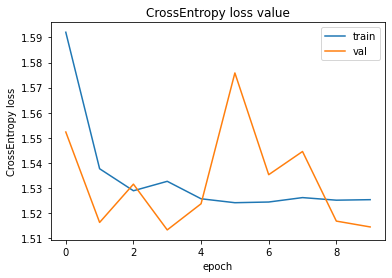

In [26]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

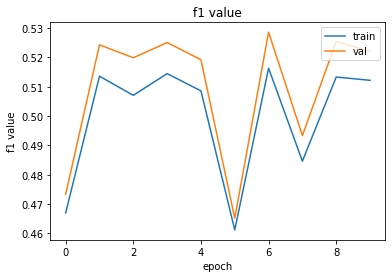

In [27]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

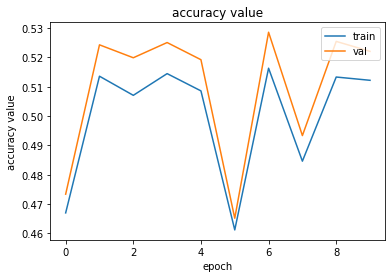

In [28]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [29]:
max(accuracy_eval)

tensor(0.5286, device='cuda:0')

### Эксперименты: дропаут before Softmax, kernel_size=4

In [30]:
model = C_LSTM(
    vocab_size=len(word2id), 
    embedding_dim=300, 
    weight_matrix=weight_matrix,
    number_of_CNN_layers=1, 
    filter_count=150, 
    kernel_sizes=[4], #  [2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]
    seq_len=1000, 
    lstm_size=150, 
    subject_num=len(subject2id), 
    dropout_place='before Softmax', #  'before Softmax', 'before CNN'
    dropout_rate=0.5
)

criterion = nn.CrossEntropyLoss() 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0.001)

In [31]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


8it [00:20,  2.50s/it]

Train loss: 1.727265328168869


16it [00:39,  2.41s/it]

Train loss: 1.680091768503189


24it [00:59,  2.44s/it]

Train loss: 1.6632544994354248


32it [01:19,  2.51s/it]

Train loss: 1.6503426730632782


40it [01:39,  2.47s/it]

Train loss: 1.6347722917795182


42it [01:42,  2.43s/it]



Evaluating on train...


8it [00:15,  1.94s/it]

Val loss: 1.5579744726419449, Val f1: 0.496826171875, Val accuracy: 0.496826171875


16it [00:37,  2.51s/it]

Val loss: 1.5545559003949165, Val f1: 0.5030517578125, Val accuracy: 0.5030517578125


24it [00:52,  1.96s/it]

Val loss: 1.5537616262833278, Val f1: 0.503662109375, Val accuracy: 0.503662109375


32it [01:08,  2.02s/it]

Val loss: 1.557564191520214, Val f1: 0.4996337890625, Val accuracy: 0.4996337890625


40it [01:24,  1.98s/it]

Val loss: 1.5567692518234253, Val f1: 0.5003906488418579, Val accuracy: 0.5003906488418579


42it [01:27,  2.07s/it]



Evaluating on test...


1it [00:01,  1.84s/it]

Val loss: 1.5265882015228271, Val f1: 0.53515625, Val accuracy: 0.53515625


2it [00:03,  1.97s/it]

Val loss: 1.550792932510376, Val f1: 0.5087890625, Val accuracy: 0.5087890625


3it [00:05,  1.93s/it]

Val loss: 1.557356556256612, Val f1: 0.5013021230697632, Val accuracy: 0.5013021230697632


4it [00:07,  1.97s/it]

Val loss: 1.552947849035263, Val f1: 0.5068359375, Val accuracy: 0.5068359375


5it [00:09,  1.82s/it]


Val loss: 1.548052930831909, Val f1: 0.5124455094337463, Val accuracy: 0.5124455094337463

starting Epoch 1
Training...


8it [00:19,  2.50s/it]

Train loss: 1.5610404014587402


16it [00:39,  2.43s/it]

Train loss: 1.5434595271945


24it [00:59,  2.45s/it]

Train loss: 1.538876270254453


32it [01:19,  2.53s/it]

Train loss: 1.5401656031608582


40it [01:39,  2.47s/it]

Train loss: 1.5379307478666306


42it [01:42,  2.45s/it]



Evaluating on train...


8it [00:15,  1.99s/it]

Val loss: 1.5215400606393814, Val f1: 0.526123046875, Val accuracy: 0.526123046875


16it [00:31,  1.92s/it]

Val loss: 1.5190892741084099, Val f1: 0.5291748046875, Val accuracy: 0.5291748046875


24it [00:47,  1.97s/it]

Val loss: 1.5186364501714706, Val f1: 0.52880859375, Val accuracy: 0.52880859375


32it [01:03,  2.05s/it]

Val loss: 1.5217972584068775, Val f1: 0.52490234375, Val accuracy: 0.52490234375


40it [01:19,  2.00s/it]

Val loss: 1.5219479262828828, Val f1: 0.524365246295929, Val accuracy: 0.524365246295929


42it [01:22,  1.96s/it]



Evaluating on test...


1it [00:01,  1.86s/it]

Val loss: 1.49452543258667, Val f1: 0.55078125, Val accuracy: 0.55078125


2it [00:03,  1.99s/it]

Val loss: 1.511239469051361, Val f1: 0.529296875, Val accuracy: 0.529296875


3it [00:05,  1.96s/it]

Val loss: 1.5170831680297852, Val f1: 0.5247396230697632, Val accuracy: 0.5247396230697632


4it [00:07,  2.00s/it]

Val loss: 1.5112715065479279, Val f1: 0.5322265625, Val accuracy: 0.5322265625


5it [00:09,  1.84s/it]


Val loss: 1.5116207361221314, Val f1: 0.53142911195755, Val accuracy: 0.53142911195755

starting Epoch 2
Training...


8it [00:19,  2.49s/it]

Train loss: 1.5287615805864334


16it [00:39,  2.43s/it]

Train loss: 1.5241887643933296


24it [00:59,  2.47s/it]

Train loss: 1.5268582850694656


32it [01:19,  2.52s/it]

Train loss: 1.5289984494447708


40it [01:39,  2.48s/it]

Train loss: 1.528662070631981


42it [01:42,  2.44s/it]



Evaluating on train...


8it [00:15,  1.96s/it]

Val loss: 1.5525328069925308, Val f1: 0.486328125, Val accuracy: 0.486328125


16it [00:31,  1.91s/it]

Val loss: 1.5489250794053078, Val f1: 0.490478515625, Val accuracy: 0.490478515625


24it [00:46,  1.95s/it]

Val loss: 1.5481744756301243, Val f1: 0.4903157651424408, Val accuracy: 0.4903157651424408


32it [01:02,  2.01s/it]

Val loss: 1.5519631914794445, Val f1: 0.4859619140625, Val accuracy: 0.4859619140625


40it [01:18,  1.97s/it]

Val loss: 1.5510819405317307, Val f1: 0.48686525225639343, Val accuracy: 0.48686525225639343


42it [01:21,  1.93s/it]



Evaluating on test...


1it [00:01,  1.83s/it]

Val loss: 1.5155484676361084, Val f1: 0.521484375, Val accuracy: 0.521484375


2it [00:03,  1.96s/it]

Val loss: 1.540004551410675, Val f1: 0.5, Val accuracy: 0.5


3it [00:05,  1.94s/it]

Val loss: 1.5489122867584229, Val f1: 0.490234375, Val accuracy: 0.490234375


4it [00:07,  1.97s/it]

Val loss: 1.545558124780655, Val f1: 0.4951171875, Val accuracy: 0.4951171875


5it [00:09,  1.82s/it]


Val loss: 1.5410016775131226, Val f1: 0.49974822998046875, Val accuracy: 0.49974822998046875

starting Epoch 3
Training...


8it [00:19,  2.46s/it]

Train loss: 1.5478178560733795


16it [00:39,  2.43s/it]

Train loss: 1.5309165492653847


24it [00:58,  2.45s/it]

Train loss: 1.5316922863324482


32it [01:19,  2.56s/it]

Train loss: 1.535683423280716


40it [01:39,  2.49s/it]

Train loss: 1.534512847661972


42it [01:42,  2.45s/it]



Evaluating on train...


8it [00:15,  1.94s/it]

Val loss: 1.517822951078415, Val f1: 0.52587890625, Val accuracy: 0.52587890625


16it [00:30,  1.89s/it]

Val loss: 1.5150570571422577, Val f1: 0.5286865234375, Val accuracy: 0.5286865234375


24it [00:46,  1.90s/it]

Val loss: 1.5147405962149303, Val f1: 0.529052734375, Val accuracy: 0.529052734375


32it [01:01,  1.99s/it]

Val loss: 1.5177734568715096, Val f1: 0.52496337890625, Val accuracy: 0.52496337890625


40it [01:17,  1.95s/it]

Val loss: 1.5178912252187728, Val f1: 0.524658203125, Val accuracy: 0.524658203125


42it [01:20,  1.91s/it]



Evaluating on test...


1it [00:01,  1.81s/it]

Val loss: 1.4875317811965942, Val f1: 0.552734375, Val accuracy: 0.552734375


2it [00:03,  1.94s/it]

Val loss: 1.5056759715080261, Val f1: 0.533203125, Val accuracy: 0.533203125


3it [00:05,  1.91s/it]

Val loss: 1.512150804201762, Val f1: 0.5266927480697632, Val accuracy: 0.5266927480697632


4it [00:07,  1.95s/it]

Val loss: 1.5069975852966309, Val f1: 0.5322265625, Val accuracy: 0.5322265625


5it [00:08,  1.80s/it]


Val loss: 1.5069887161254882, Val f1: 0.5320935249328613, Val accuracy: 0.5320935249328613

starting Epoch 4
Training...


8it [00:19,  2.47s/it]

Train loss: 1.529102623462677


16it [00:39,  2.40s/it]

Train loss: 1.5230123177170753


24it [00:58,  2.43s/it]

Train loss: 1.5211178362369537


32it [01:18,  2.50s/it]

Train loss: 1.5257321931421757


40it [01:38,  2.46s/it]

Train loss: 1.5248026639223098


42it [01:41,  2.43s/it]



Evaluating on train...


8it [00:15,  1.97s/it]

Val loss: 1.5287458449602127, Val f1: 0.510986328125, Val accuracy: 0.510986328125


16it [00:31,  1.90s/it]

Val loss: 1.524858720600605, Val f1: 0.514404296875, Val accuracy: 0.514404296875


24it [00:46,  1.93s/it]

Val loss: 1.5240349471569061, Val f1: 0.5146484375, Val accuracy: 0.5146484375


32it [01:02,  1.98s/it]

Val loss: 1.5277340151369572, Val f1: 0.51116943359375, Val accuracy: 0.51116943359375


40it [01:18,  1.96s/it]

Val loss: 1.527423506975174, Val f1: 0.5110840201377869, Val accuracy: 0.5110840201377869


42it [01:20,  1.92s/it]



Evaluating on test...


1it [00:01,  1.82s/it]

Val loss: 1.4869197607040405, Val f1: 0.56640625, Val accuracy: 0.56640625


2it [00:03,  1.97s/it]

Val loss: 1.5162054896354675, Val f1: 0.5302734375, Val accuracy: 0.5302734375


3it [00:05,  1.92s/it]

Val loss: 1.5239386558532715, Val f1: 0.51953125, Val accuracy: 0.51953125


4it [00:07,  1.95s/it]

Val loss: 1.5195408165454865, Val f1: 0.5224609375, Val accuracy: 0.5224609375


5it [00:09,  1.80s/it]


Val loss: 1.5155543327331542, Val f1: 0.5256099700927734, Val accuracy: 0.5256099700927734

starting Epoch 5
Training...


8it [00:19,  2.47s/it]

Train loss: 1.5534365475177765


16it [00:39,  2.42s/it]

Train loss: 1.5383535325527191


24it [00:58,  2.45s/it]

Train loss: 1.5317386140426


32it [01:18,  2.50s/it]

Train loss: 1.5325214006006718


40it [01:38,  2.46s/it]

Train loss: 1.5302666008472443


42it [01:41,  2.43s/it]



Evaluating on train...


8it [00:15,  1.98s/it]

Val loss: 1.5359717309474945, Val f1: 0.503662109375, Val accuracy: 0.503662109375


16it [00:31,  1.89s/it]

Val loss: 1.531338319182396, Val f1: 0.5098876953125, Val accuracy: 0.5098876953125


24it [00:46,  1.91s/it]

Val loss: 1.530707026521365, Val f1: 0.5093587636947632, Val accuracy: 0.5093587636947632


32it [01:02,  2.00s/it]

Val loss: 1.5345119051635265, Val f1: 0.50531005859375, Val accuracy: 0.50531005859375


40it [01:17,  1.93s/it]

Val loss: 1.534057718515396, Val f1: 0.5054687857627869, Val accuracy: 0.5054687857627869


42it [01:20,  1.92s/it]



Evaluating on test...


1it [00:01,  1.79s/it]

Val loss: 1.4975802898406982, Val f1: 0.544921875, Val accuracy: 0.544921875


2it [00:03,  1.93s/it]

Val loss: 1.5237593054771423, Val f1: 0.513671875, Val accuracy: 0.513671875


3it [00:05,  1.91s/it]

Val loss: 1.5314432779947917, Val f1: 0.505859375, Val accuracy: 0.505859375


4it [00:07,  1.94s/it]

Val loss: 1.5276149213314056, Val f1: 0.51025390625, Val accuracy: 0.51025390625


5it [00:08,  1.79s/it]


Val loss: 1.5231719255447387, Val f1: 0.5171732306480408, Val accuracy: 0.5171732306480408

starting Epoch 6
Training...


8it [00:19,  2.47s/it]

Train loss: 1.5478953570127487


16it [00:39,  2.41s/it]

Train loss: 1.534089669585228


24it [00:58,  2.42s/it]

Train loss: 1.5299199223518372


32it [01:18,  2.51s/it]

Train loss: 1.5308513902127743


40it [01:38,  2.46s/it]

Train loss: 1.5300040245056152


42it [01:41,  2.42s/it]



Evaluating on train...


8it [00:15,  1.94s/it]

Val loss: 1.5203472077846527, Val f1: 0.52294921875, Val accuracy: 0.52294921875


16it [00:30,  1.89s/it]

Val loss: 1.5181597396731377, Val f1: 0.5250244140625, Val accuracy: 0.5250244140625


24it [00:45,  1.91s/it]

Val loss: 1.5180805921554565, Val f1: 0.5255534052848816, Val accuracy: 0.5255534052848816


32it [01:01,  1.97s/it]

Val loss: 1.5207743309438229, Val f1: 0.52227783203125, Val accuracy: 0.52227783203125


40it [01:17,  1.94s/it]

Val loss: 1.5213344097137451, Val f1: 0.5218750238418579, Val accuracy: 0.5218750238418579


42it [01:19,  1.90s/it]



Evaluating on test...


1it [00:01,  1.79s/it]

Val loss: 1.4991250038146973, Val f1: 0.546875, Val accuracy: 0.546875


2it [00:03,  1.91s/it]

Val loss: 1.5089303851127625, Val f1: 0.5361328125, Val accuracy: 0.5361328125


3it [00:05,  1.88s/it]

Val loss: 1.5127970774968464, Val f1: 0.5325521230697632, Val accuracy: 0.5325521230697632


4it [00:07,  1.92s/it]

Val loss: 1.5062261521816254, Val f1: 0.54052734375, Val accuracy: 0.54052734375


5it [00:08,  1.77s/it]


Val loss: 1.5075751543045044, Val f1: 0.5367408394813538, Val accuracy: 0.5367408394813538

starting Epoch 7
Training...


8it [00:19,  2.47s/it]

Train loss: 1.534727230668068


16it [00:39,  2.41s/it]

Train loss: 1.5252737626433372


24it [00:58,  2.43s/it]

Train loss: 1.5213507562875748


32it [01:18,  2.50s/it]

Train loss: 1.5273681953549385


40it [01:38,  2.47s/it]

Train loss: 1.526599571108818


42it [01:41,  2.42s/it]



Evaluating on train...


8it [00:15,  1.94s/it]

Val loss: 1.5355505645275116, Val f1: 0.522705078125, Val accuracy: 0.522705078125


16it [00:30,  1.90s/it]

Val loss: 1.5331705510616302, Val f1: 0.5255126953125, Val accuracy: 0.5255126953125


24it [00:46,  1.91s/it]

Val loss: 1.5323850860198338, Val f1: 0.52587890625, Val accuracy: 0.52587890625


32it [01:02,  1.99s/it]

Val loss: 1.5351417362689972, Val f1: 0.52215576171875, Val accuracy: 0.52215576171875


40it [01:17,  1.93s/it]

Val loss: 1.535930687189102, Val f1: 0.521533191204071, Val accuracy: 0.521533191204071


42it [01:20,  1.91s/it]



Evaluating on test...


1it [00:01,  1.80s/it]

Val loss: 1.5180788040161133, Val f1: 0.533203125, Val accuracy: 0.533203125


2it [00:03,  1.92s/it]

Val loss: 1.526638388633728, Val f1: 0.529296875, Val accuracy: 0.529296875


3it [00:05,  1.88s/it]

Val loss: 1.5301707188288372, Val f1: 0.525390625, Val accuracy: 0.525390625


4it [00:07,  1.92s/it]

Val loss: 1.522159218788147, Val f1: 0.5361328125, Val accuracy: 0.5361328125


5it [00:08,  1.78s/it]


Val loss: 1.5227721452713012, Val f1: 0.534554123878479, Val accuracy: 0.534554123878479

starting Epoch 8
Training...


8it [00:19,  2.47s/it]

Train loss: 1.5314593315124512


16it [00:39,  2.42s/it]

Train loss: 1.5233469307422638


24it [00:58,  2.45s/it]

Train loss: 1.521349514524142


32it [01:25,  3.59s/it]

Train loss: 1.5232967473566532


40it [01:49,  2.73s/it]

Train loss: 1.5228086829185485


42it [01:52,  2.68s/it]



Evaluating on train...


8it [00:15,  1.97s/it]

Val loss: 1.5201418846845627, Val f1: 0.51904296875, Val accuracy: 0.51904296875


16it [00:31,  1.93s/it]

Val loss: 1.5150125846266747, Val f1: 0.5260009765625, Val accuracy: 0.5260009765625


24it [00:46,  1.94s/it]

Val loss: 1.514374241232872, Val f1: 0.5262858271598816, Val accuracy: 0.5262858271598816


32it [01:02,  2.01s/it]

Val loss: 1.5180172584950924, Val f1: 0.5225830078125, Val accuracy: 0.5225830078125


40it [01:18,  1.94s/it]

Val loss: 1.5177732348442077, Val f1: 0.5226074457168579, Val accuracy: 0.5226074457168579


42it [01:20,  1.93s/it]



Evaluating on test...


1it [00:01,  1.78s/it]

Val loss: 1.4817756414413452, Val f1: 0.564453125, Val accuracy: 0.564453125


2it [00:03,  1.91s/it]

Val loss: 1.507649540901184, Val f1: 0.533203125, Val accuracy: 0.533203125


3it [00:05,  1.89s/it]

Val loss: 1.5138496955235798, Val f1: 0.5299479365348816, Val accuracy: 0.5299479365348816


4it [00:07,  1.94s/it]

Val loss: 1.5098768472671509, Val f1: 0.533203125, Val accuracy: 0.533203125


5it [00:08,  1.78s/it]


Val loss: 1.5067087411880493, Val f1: 0.5368615388870239, Val accuracy: 0.5368615388870239

starting Epoch 9
Training...


8it [00:19,  2.47s/it]

Train loss: 1.5391563922166824


16it [00:39,  2.40s/it]

Train loss: 1.527927502989769


24it [00:58,  2.47s/it]

Train loss: 1.5290555159250896


32it [01:19,  2.58s/it]

Train loss: 1.5360842011868954


40it [01:39,  2.51s/it]

Train loss: 1.5323964774608612


42it [01:42,  2.45s/it]



Evaluating on train...


8it [00:15,  1.99s/it]

Val loss: 1.5648333132266998, Val f1: 0.474853515625, Val accuracy: 0.474853515625


16it [00:31,  1.93s/it]

Val loss: 1.5605822950601578, Val f1: 0.480712890625, Val accuracy: 0.480712890625


24it [00:46,  1.95s/it]

Val loss: 1.558044637242953, Val f1: 0.4832356870174408, Val accuracy: 0.4832356870174408


32it [01:02,  1.99s/it]

Val loss: 1.563132368028164, Val f1: 0.4779052734375, Val accuracy: 0.4779052734375


40it [01:18,  1.97s/it]

Val loss: 1.561661458015442, Val f1: 0.47900390625, Val accuracy: 0.47900390625


42it [01:21,  1.94s/it]



Evaluating on test...


1it [00:01,  1.83s/it]

Val loss: 1.5318994522094727, Val f1: 0.50390625, Val accuracy: 0.50390625


2it [00:03,  1.95s/it]

Val loss: 1.552704095840454, Val f1: 0.486328125, Val accuracy: 0.486328125


3it [00:05,  1.92s/it]

Val loss: 1.561958948771159, Val f1: 0.4772135615348816, Val accuracy: 0.4772135615348816


4it [00:07,  1.96s/it]

Val loss: 1.5576024651527405, Val f1: 0.482421875, Val accuracy: 0.482421875


5it [00:09,  1.81s/it]

Val loss: 1.550862455368042, Val f1: 0.4895919859409332, Val accuracy: 0.4895919859409332


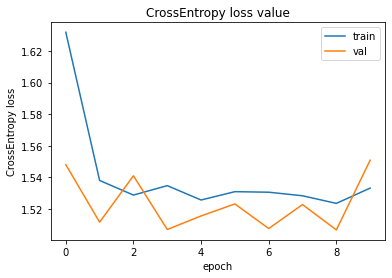

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

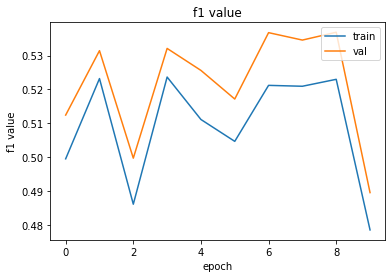

In [33]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

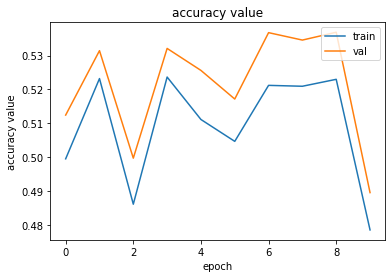

In [34]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy value')
plt.ylabel('accuracy value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [35]:
max(accuracy_eval)

tensor(0.5369, device='cuda:0')

Добавление дропаута только ухудшило ситуацию. По лоссу видно, что ничего не обучается, на трейне он практически не снижается большую часть обучения, а все остальные метрики мотает из стороны в сторону примерно в том же диапазоне, что и в экспериментах на фильтрах. Когда мы обучали фильтр 4 без дропаутов, процесс проходил более предсказуемо (лосс падал, метрики увеличивались) в течение времени.

В целом, мне кажется, что dropout_rate, используемый в архитектуре авторами, слишком большой.